In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from collections import deque
from typing import List, Tuple, Callable, Optional
np.random.seed(1234)

# üß¨ Resoluci√≥n del problema de las N-reinas mediante Algoritmos Gen√©ticos (AG)

Este proyecto aborda la resoluci√≥n del cl√°sico problema de las N-reinas utilizando Algoritmos Gen√©ticos (AG), una t√©cnica inspirada en los procesos evolutivos de la naturaleza.

El objetivo del problema es colocar N reinas en un tablero de ajedrez de NxN de forma que ninguna pueda atacar a otra, es decir, que no compartan fila, columna ni diagonal. Aunque la soluci√≥n puede encontrarse mediante enfoques cl√°sicos como el backtracking, aqu√≠ se propone una alternativa basada en inteligencia artificial evolutiva, capaz de buscar soluciones eficientes incluso para valores grandes de N.

## 1. Par√°metros iniciales:

### 1.1. Representaci√≥n del individuo

En este proyecto, cada individuo de la poblaci√≥n ser√° representado mediante una **permutaci√≥n de N n√∫meros**, donde cada n√∫mero indica la **fila** en la que se ubica una reina, y su posici√≥n en el vector representa la **columna** correspondiente.

Por ejemplo, el cromosoma:

(1 3 2 4)


se interpreta como:
- La reina de la **fila 1** est√° en la **columna 1**,
- La reina de la **fila 2** est√° en la **columna 3**,
- La reina de la **fila 3** est√° en la **columna 2**,
- La reina de la **fila 4** est√° en la **columna 4**.

Esta representaci√≥n garantiza autom√°ticamente que **no haya conflictos en columnas ni filas**, ya que cada n√∫mero (fila) y cada posici√≥n (columna) del vector son √∫nicos.  
Por lo tanto, la evaluaci√≥n se centra exclusivamente en detectar **conflictos en diagonales**, lo que simplifica la funci√≥n de aptitud.

### 1.2. Evaluaci√≥n (funci√≥n de aptitud / fitness)

En el problema de las N-reinas, el objetivo es colocar \( N \) reinas en un tablero de \( N x N \) de forma que ninguna de las reinas se ataque. Las reinas se atacan si est√°n en la misma fila, columna o diagonal. La funci√≥n de fitness que se presenta eval√∫a cu√°ntas parejas de reinas no se atacan entre s√≠ diagonalmente. Cuanto mayor sea el valor de fitness, mejor es la disposici√≥n de las reinas en el tablero.

La f√≥rmula matem√°tica para la funci√≥n de fitness es la siguiente:

$$
\text{fitness}(\text{poblaci√≥n}) = \sum_{i=1}^{n} \sum_{j=i+1}^{n} \left[ \left| \text{individuo}[i] - \text{individuo}[j] \right| == \left| i - j \right| \right]
$$


Para facilitar la programaci√≥n del algoritmo, crearemos una clase para representar el cromosoma junto a la funci√≥n de fitness:

In [2]:
def fitness(cromosoma: List[int]) -> int:
    """
    Calcula el valor de fitness de un cromosoma para el problema de las N-reinas.
    
    :param cromosoma: Una lista de enteros que representa la disposici√≥n de las reinas en el tablero.
    :return: Un valor entero que indica el fitness del cromosoma.
    """
    fitness = 0
    for i in range(len(cromosoma)):
        for j in range(i + 1, len(cromosoma)):
            fitness += (np.abs(cromosoma[i] - cromosoma[j]) == np.abs(i - j))
                    
    return fitness

In [3]:
class Individuo:
    def __init__(self, 
                 N_cromosoma: int, 
                 f_fitness: Callable[[List[int]], int], 
                 cromosoma: Optional[List[int]] = None) -> None:
        """
        Inicializa un individuo con un cromosoma aleatorio o proporcionado, y calcula su fitness.
        
        :param N_cromosoma: N√∫mero de reinas (tama√±o del tablero).
        :param f_fitness: Funci√≥n de fitness que eval√∫a un cromosoma.
        :param cromosoma: Una lista de enteros representando la disposici√≥n de las reinas. Si no se proporciona, se genera aleatoriamente.
        """
        self.N_cromosoma = N_cromosoma
        if cromosoma is None:
            # Genera un cromosoma aleatorio
            self.cromosoma = random.sample(range(N_cromosoma), N_cromosoma)
        else:
            self.cromosoma = cromosoma
        self.f_fitness = f_fitness
        # Calcula el fitness del individuo
        self.fitness = f_fitness(self.cromosoma)

    def mostrar_individuo(self) -> None:
        """
        Muestra el cromosoma y el fitness del individuo.
        """
        print("Cromosoma:", self.cromosoma)
        print("Fitness:", self.fitness)


Probamos la clase creada:

In [4]:
individuo = Individuo(N_cromosoma=4, f_fitness=fitness)
individuo.mostrar_individuo()

Cromosoma: [2, 1, 0, 3]
Fitness: 4


### 1.3. Representaci√≥n y generaci√≥n de la poblaci√≥n:

En un algoritmo gen√©tico, la poblaci√≥n representa el conjunto de posibles soluciones al problema que estamos tratando de resolver. Cada individuo dentro de la poblaci√≥n es una soluci√≥n candidata que ser√° evaluada y, en funci√≥n de su calidad (fitness), podr√° reproducirse, mutar o ser reemplazada a lo largo de las generaciones.

En este caso, vamos a crear una **clase Poblaci√≥n** que se encargar√° de representar y gestionar la poblaci√≥n de individuos. Esta clase incluir√° m√©todos para:

1. **Generar la poblaci√≥n inicial**: Crearemos una poblaci√≥n inicial de individuos de manera aleatoria, bas√°ndonos en las reglas del problema (en este caso, el problema de las N-reinas). Cada individuo representar√° una posible disposici√≥n de las reinas en el tablero.
   
2. **Evaluar la poblaci√≥n**: Evaluaremos el fitness de cada individuo en la poblaci√≥n utilizando la funci√≥n de fitness definida anteriormente. Esto nos permitir√° medir qu√© tan "buena" es cada soluci√≥n en t√©rminos de su capacidad para resolver el problema de las N-reinas.

3. **Gestionar la poblaci√≥n**: La clase tambi√©n se encargar√° de gestionar la poblaci√≥n a lo largo de las generaciones, permitiendo operaciones como la selecci√≥n de progenitores, la reproducci√≥n (cruce) y la mutaci√≥n.

Al crear esta clase, podemos abstraer la complejidad de manejar la poblaci√≥n de manera organizada, facilitando la implementaci√≥n y el mantenimiento del algoritmo gen√©tico.

### Objetivos:
- **Representar la poblaci√≥n de individuos** de manera eficiente.
- **Gestionar las operaciones** de selecci√≥n, cruce y mutaci√≥n en la poblaci√≥n a lo largo de las generaciones.
- **Evaluar el fitness** de los individuos y seleccionar a los mejores para la reproducci√≥n.

De esta manera, la clase Poblaci√≥n servir√° como el n√∫cleo para las interacciones entre los individuos y las generaciones del algoritmo gen√©tico.


In [5]:
class Poblacion:
    def __init__(self, 
                 N_poblacion: int, 
                 N_cromosoma: int, 
                 f_fitness: Callable[[List[int]], int], 
                 individuos: Optional[List[Individuo]] = None) -> None:
        """
        Inicializa una poblaci√≥n de individuos para el algoritmo gen√©tico.

        :param N_poblacion: N√∫mero de individuos en la poblaci√≥n.
        :param N_cromosoma: N√∫mero de reinas (dimensi√≥n del cromosoma).
        :param f_fitness: Funci√≥n de fitness que eval√∫a el cromosoma de cada individuo.
        :param individuos: Lista opcional de individuos. Si no se proporciona, se generar√° una poblaci√≥n aleatoria.
        """
        self.N_poblacion = N_poblacion
        self.N_cromosoma = N_cromosoma
        # Inicializamos los individuos
        if individuos is None:
            self.individuos = [Individuo(N_cromosoma=N_cromosoma, f_fitness=f_fitness) 
                               for _ in range(N_poblacion)]
        else:
            self.individuos = individuos

        # Calculamos los fitness de la poblaci√≥n
        self.fitness_poblacion = [individuo.fitness for individuo in self.individuos]
        self.fitness_medio = np.mean(self.fitness_poblacion)

    def mostrar_poblacion(self) -> None:
        """
        Muestra todos los individuos de la poblaci√≥n con su cromosoma y su fitness.
        """
        for idx, individuo in enumerate(self.individuos):
            print(f"Individuo {idx}:")
            individuo.mostrar_individuo()
            print()


Probamos la clase creada:

In [6]:
poblacion = Poblacion(N_poblacion=5, N_cromosoma=4, f_fitness=fitness)
poblacion.mostrar_poblacion()

Individuo 0:
Cromosoma: [2, 3, 0, 1]
Fitness: 4

Individuo 1:
Cromosoma: [1, 0, 3, 2]
Fitness: 4

Individuo 2:
Cromosoma: [0, 3, 2, 1]
Fitness: 4

Individuo 3:
Cromosoma: [0, 1, 2, 3]
Fitness: 6

Individuo 4:
Cromosoma: [3, 1, 2, 0]
Fitness: 2



### 1.4. Selecci√≥n de progenitores:

En los algoritmos gen√©ticos, la selecci√≥n de progenitores es un paso clave para generar nuevas soluciones a partir de la poblaci√≥n actual. Se busca elegir a los individuos m√°s aptos para reproducirse y generar descendencia, de manera que las mejores soluciones tengan una mayor probabilidad de ser seleccionadas.

En este caso, se utilizar√° el **m√©todo de la ruleta**, tambi√©n conocido como **selecci√≥n proporcional al ajuste** o **selecci√≥n basada en fitness**. Este m√©todo simula una ruleta en la que cada individuo tiene un espacio proporcional a su valor de fitness. Cuanto menor sea el fitness de un individuo, mayor ser√° su probabilidad de ser seleccionado como progenitor.

El proceso funciona de la siguiente manera:
1. **Calcular el fitness invertido de los individuos**: max_fitness(poblacion) - fitness(individuo).
2. **Asignar una probabilidad de selecci√≥n**: Cada individuo tiene una probabilidad de ser seleccionado que es proporcional a su fitness invertido. Es decir, los individuos con un fitness menor tienen m√°s probabilidades de ser elegidos.
3. **Seleccionar progenitores**: Se realiza una selecci√≥n aleatoria, donde la probabilidad de selecci√≥n de cada individuo es proporcional a su fitness invertido. Este proceso se repite hasta que se elijan los progenitores necesarios para la reproducci√≥n. Se hace una selecci√≥n sin reemplazamiento.

In [7]:
def seleccionar_progenitores_ruleta(poblacion: 'Poblacion', N_progenitores: int) -> List['Individuo']:
    """
    Selecciona un n√∫mero de progenitores de la poblaci√≥n utilizando el m√©todo de la ruleta,
    donde los individuos con mejor fitness (fitness m√°s bajo) tienen mayor probabilidad de ser seleccionados.
    La selecci√≥n es sin reemplazo, lo que evita que un individuo sea seleccionado m√°s de una vez.

    :param poblacion: La poblaci√≥n de individuos de la cual se seleccionan los progenitores.
    :param N_progenitores: El n√∫mero de progenitores que se desean seleccionar.
    :return: Una lista de progenitores seleccionados.
    """
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + np.array(poblacion.fitness_poblacion))

    # Seleccionamos los progenitores sin reemplazo
    progenitores_indices = np.random.choice(len(poblacion.individuos), size=N_progenitores, replace=False, p=fitness_invertido / np.sum(fitness_invertido))
    
    progenitores = [poblacion.individuos[i] for i in progenitores_indices]

    return progenitores

In [8]:
progenitores = seleccionar_progenitores_ruleta(poblacion, 2)
for idx, progenitor in enumerate(progenitores):
    print(f"Progenitor {idx}:")
    progenitor.mostrar_individuo()
    print()

Progenitor 0:
Cromosoma: [1, 0, 3, 2]
Fitness: 4

Progenitor 1:
Cromosoma: [0, 1, 2, 3]
Fitness: 6



### 1.5. Cruzamiento de los progenitores:

Una vez seleccionados los progenitores, se realiza el cruzamiento con el objetivo de combinar la informaci√≥n gen√©tica de dos individuos y generar nuevos cromosomas (descendientes) que hereden caracter√≠sticas de ambos padres.
Para este problema, donde los cromosomas representan permutaciones v√°lidas (como en el caso del problema de las N-reinas), utilizamos el Cruzamiento Parcialmente Mapeado (PMX). Este m√©todo asegura que los hijos generados tambi√©n sean permutaciones v√°lidas, evitando duplicados y manteniendo la diversidad gen√©tica.
El PMX conserva bloques de genes del primer progenitor y completa el resto del cromosoma respetando el orden y la posici√≥n relativa de los genes del segundo progenitor, mediante un sistema de correspondencias.

In [9]:
def cruzar_progenitores_pmx(progenitor1: 'Individuo', progenitor2: 'Individuo') -> 'Individuo':
    """
    Realiza el cruzamiento parcialmente mapeado (PMX) entre dos progenitores,
    generando un solo descendiente.

    :param progenitor1: Primer progenitor (objeto Individuo).
    :param progenitor2: Segundo progenitor (objeto Individuo).
    :return: Objeto Individuo descendiente del cruzamiento.
    """
    p1 = np.array(progenitor1.cromosoma)
    p2 = np.array(progenitor2.cromosoma)
    N = len(p1)

    # Seleccionamos dos puntos de corte aleatorios
    punto1, punto2 = sorted(random.sample(range(N), 2))

    offspring = np.empty(N, dtype=p1.dtype)
    offspring[punto1:punto2] = p1[punto1:punto2]

    # Copiamos el resto desde p2, resolviendo conflictos por mapeo
    for i in np.concatenate((np.arange(0, punto1), np.arange(punto2, N))):
        candidate = p2[i]
        while candidate in p1[punto1:punto2]:
            candidate = p2[np.where(p1 == candidate)[0][0]]
        offspring[i] = candidate

    return Individuo(N_cromosoma=N,
                     f_fitness=progenitor1.f_fitness,
                     cromosoma=offspring.tolist())

In [10]:
hijo = cruzar_progenitores_pmx(progenitor1=progenitores[0], 
                           progenitor2=progenitores[1])
hijo.mostrar_individuo()

Cromosoma: [1, 0, 2, 3]
Fitness: 2


### 1.6. Mutaci√≥n de los descendientes:

Despu√©s del cruzamiento, se aplica una operaci√≥n de mutaci√≥n con el objetivo de introducir variaci√≥n gen√©tica y evitar que la poblaci√≥n se estanque en soluciones sub√≥ptimas.

En este caso, utilizaremos la **Mutaci√≥n por sacudida**, una t√©cnica adecuada para problemas de permutaci√≥n como las N-reinas.

Esta mutaci√≥n consiste en seleccionar dos posiciones aleatorias dentro del cromosoma y reordenar aleatoriamente (hacer un *shuffle*) todos los genes comprendidos entre esas dos posiciones.  
Este enfoque permite una modificaci√≥n m√°s significativa del cromosoma, explorando nuevas configuraciones sin violar la restricci√≥n de que todos los genes deben ser √∫nicos.

Esta estrategia es efectiva para mantener la diversidad y fomentar la exploraci√≥n del espacio de soluciones.


In [11]:
def mutar_individuo_sacudida(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutaci√≥n por sacudida a un cromosoma.
    Se selecciona un segmento aleatorio dentro del cromosoma
    y se reordenan aleatoriamente los genes dentro de ese segmento.

    :param cromosoma: Cromosoma original (permutaci√≥n de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos √≠ndices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Mezclar aleatoriamente los elementos entre i y j (inclusive)
    segmento = mutado[i:j+1]
    random.shuffle(segmento)
    mutado[i:j+1] = segmento

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

In [12]:
mutado = mutar_individuo_sacudida(individuo)
print("Individuo sin mutar: ")
individuo.mostrar_individuo()
print()
print("Individuo mutado: ")
mutado.mostrar_individuo()

Individuo sin mutar: 
Cromosoma: [2, 1, 0, 3]
Fitness: 4

Individuo mutado: 
Cromosoma: [2, 1, 3, 0]
Fitness: 1


### 1.7. Selecci√≥n de Supervivientes:

Una vez que se han generado los descendientes a trav√©s del cruzamiento y la mutaci√≥n, se procede a la **selecci√≥n de supervivientes** para conformar la siguiente generaci√≥n.

En esta etapa, se combinan los individuos de la generaci√≥n actual con los nuevos descendientes, y se seleccionan los **mejores N individuos** en funci√≥n de su valor de fitness.

Dado que el objetivo del problema de las N-reinas es minimizar el n√∫mero de conflictos (es decir, minimizar el valor del fitness), se eligen los **N individuos con menor fitness** para asegurar que la poblaci√≥n evolucione hacia soluciones m√°s √≥ptimas en cada generaci√≥n.

In [13]:
import numpy as np
from typing import List

def seleccionar_supervivientes_ruleta(poblacion: 'Poblacion', descendientes: List['Individuo']) -> 'Poblacion':
    """
    Selecciona a los mejores individuos de la poblaci√≥n actual y los descendientes utilizando el m√©todo de la ruleta.
    Los individuos con mejor fitness (fitness m√°s bajo) tienen mayor probabilidad de ser seleccionados.

    :param poblacion: Objeto de la clase Poblacion que representa la poblaci√≥n actual.
    :param descendientes: Lista de individuos generados en la √∫ltima generaci√≥n (descendientes).
    :return: Nueva poblaci√≥n formada por los mejores individuos seleccionados.
    """
    # Agregamos los descendientes a la poblaci√≥n actual
    individuos = poblacion.individuos + descendientes
    f_fitness = individuos[0].f_fitness
    
    # Obtenemos los fitness de todos los individuos
    fitness_poblacion = np.array([individuo.fitness for individuo in individuos])
    
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + fitness_poblacion)  # Sumamos 1 para evitar divisi√≥n por 0
    
    # Normalizamos las probabilidades
    probabilidades = fitness_invertido / np.sum(fitness_invertido)
    
    # Seleccionamos los supervivientes (mismo tama√±o que la poblaci√≥n original)
    supervivientes_indices = np.random.choice(len(individuos), size=poblacion.N_poblacion, replace=False, p=probabilidades)
    
    supervivientes = [individuos[i] for i in supervivientes_indices]
    
    # Creamos una nueva poblaci√≥n con los mejores individuos seleccionados
    poblacion_superviviente = Poblacion(
        N_poblacion=poblacion.N_poblacion,
        N_cromosoma=poblacion.N_cromosoma,
        f_fitness=f_fitness,
        individuos=supervivientes
    )
    
    return poblacion_superviviente


Probamos la funci√≥n creada:

In [14]:
# Inicializamos la poblaci√≥n con 5 individuos, cada uno con un cromosoma de longitud 4.
poblacion = Poblacion(N_poblacion=5, 
                      N_cromosoma=4, 
                      f_fitness=fitness)

# Seleccionamos 2 progenitores basados en su fitness.
progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=2)

# Cruzamos los progenitores para crear los hijos.
hijo1 = cruzar_progenitores_pmx(progenitor1=progenitores[0],
                             progenitor2=progenitores[1])
hijo2 = cruzar_progenitores_pmx(progenitor1=progenitores[1],
                             progenitor2=progenitores[0])

# Mutamos el primer hijo intercambiando aleatoriamente dos posiciones en su cromosoma.
mutado = mutar_individuo_sacudida(individuo=hijo1)

# Seleccionamos los mejores individuos para la siguiente generaci√≥n.
poblacion_superviviente = seleccionar_supervivientes_ruleta(poblacion, [mutado, hijo1, hijo2])

# Mostramos la nueva poblaci√≥n de supervivientes.
poblacion_superviviente.mostrar_poblacion()


Individuo 0:
Cromosoma: [3, 2, 1, 0]
Fitness: 6

Individuo 1:
Cromosoma: [3, 0, 1, 2]
Fitness: 4

Individuo 2:
Cromosoma: [3, 2, 1, 0]
Fitness: 6

Individuo 3:
Cromosoma: [3, 0, 1, 2]
Fitness: 4

Individuo 4:
Cromosoma: [1, 0, 3, 2]
Fitness: 4



### 1.8. Implementaci√≥n del algoritmo gen√©tico:

Crearemos una funci√≥n que implemente el algoritmo gen√©tico:

In [15]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo gen√©tico para resolver el problema de las N-reinas.

    :param N_poblacion: N√∫mero de individuos en la poblaci√≥n.
    :param N_cromosoma: Tama√±o del cromosoma (N del problema).
    :param f_fitness: Funci√≥n de evaluaci√≥n de fitness.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutaci√≥n.
    :param num_iteraciones: N√∫mero de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evoluci√≥n del fitness por generaci√≥n, y 
        la evoluci√≥n del fitness medio por generaci√≥n.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []
    iteraciones = 0
    while(True):
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)

        # Si hemos alcanzado una soluci√≥n, finalizamos
        if np.min(poblacion.fitness_poblacion) == 0:
            break
        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=2)
        progenitor1, progenitor2 = progenitores[0], progenitores[1]

        if np.random.rand() <= prob_cruz:
            # Generamos el primer hijo
            hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                       progenitor2=progenitor2)

            if np.random.rand() <= prob_mut:
                hijo1 = mutar_individuo_sacudida(hijo1)
            descendientes.append(hijo1)

            # Generamos el segundo hijo
            hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                       progenitor2=progenitor1)

            if np.random.rand() <= prob_mut:
                hijo2 = mutar_individuo_sacudida(hijo2)
            descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Crearemos una funci√≥n para visualizar la evoluci√≥n del mejor fitness y el fitness medio:

In [16]:
def crear_grafico_fitness(
    mejor_fitness: List[int],
    fitness_medio: List[float],
    N_reinas: int,
    tam_poblacion: int,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Crea un gr√°fico de evoluci√≥n del fitness en el eje proporcionado o en uno nuevo.

    :param mejor_fitness: Lista con el mejor fitness por generaci√≥n.
    :param fitness_medio: Lista con el fitness medio por generaci√≥n.
    :param N_reinas: N√∫mero de reinas del problema (N).
    :param tam_poblacion: Tama√±o de la poblaci√≥n utilizada.
    :param ax: Objeto Axes en el que se dibujar√° el gr√°fico (opcional).
    :return: Objeto Axes con la gr√°fica generada.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    mejor_fitness_final = min(mejor_fitness)

    ax.plot(mejor_fitness, label="Mejor Fitness", color="green")
    ax.plot(fitness_medio, label="Fitness Medio", color="blue")
    ax.set_xlabel("Generaciones")
    ax.set_ylabel("Fitness")
    ax.set_title(f"N={N_reinas}, Poblaci√≥n={tam_poblacion}\nMejor Fitness: {mejor_fitness_final}")
    ax.legend()
    ax.grid(True)

    return ax



Ejecutaremos el algoritmos gen√©tico para distintas N-s.

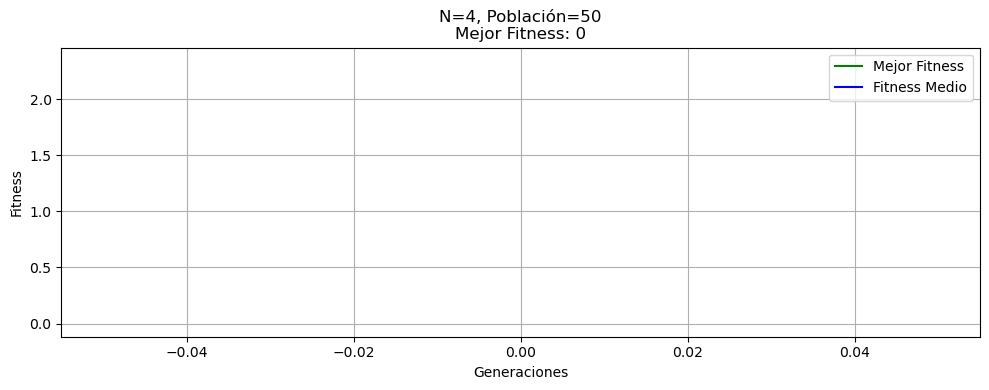

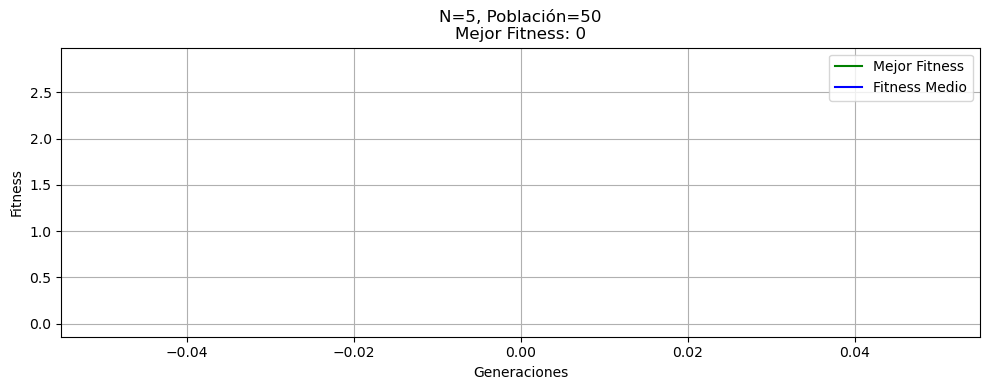

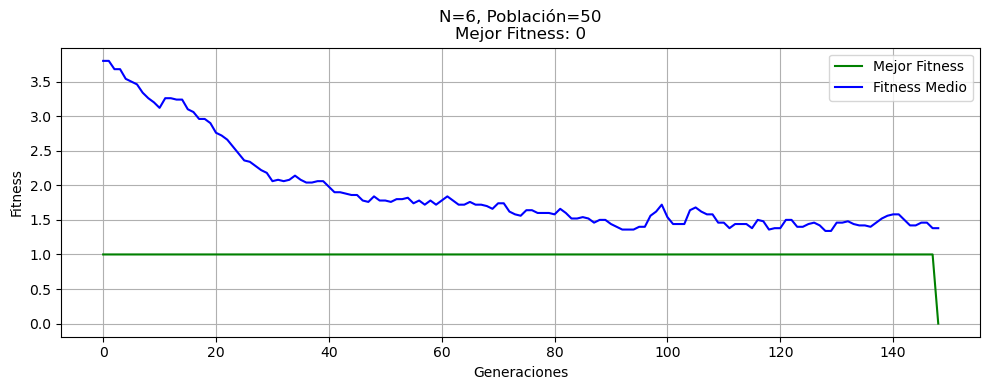

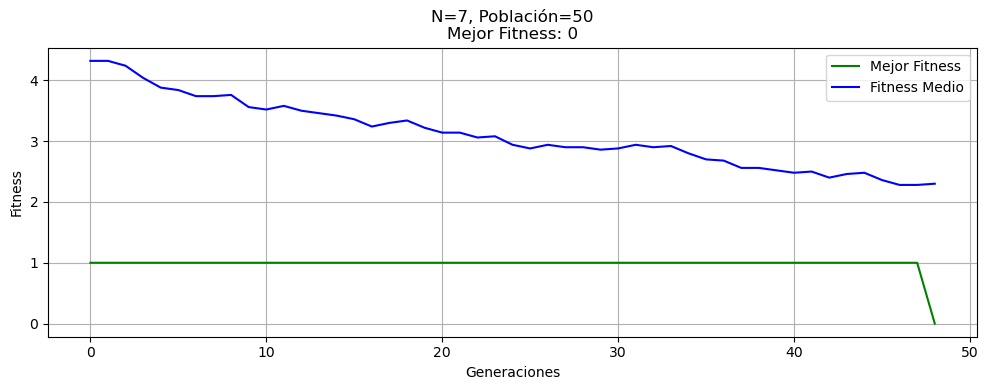

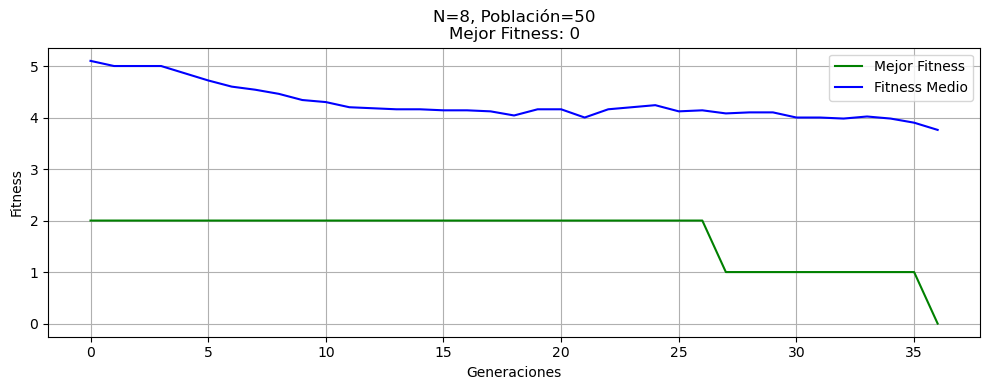

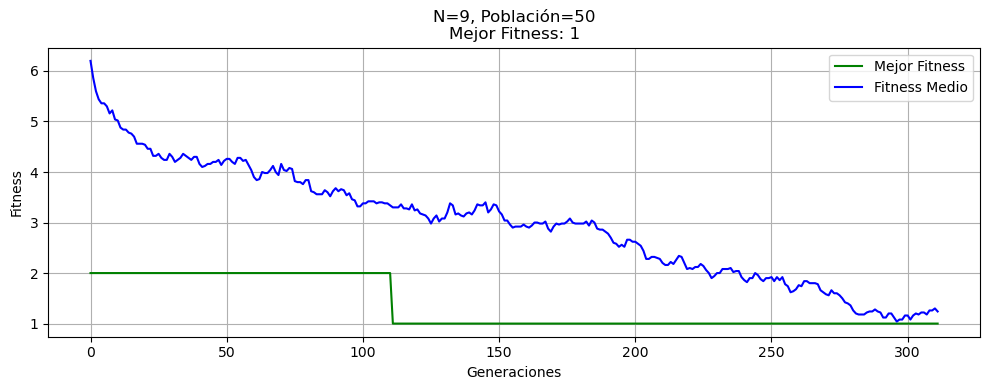

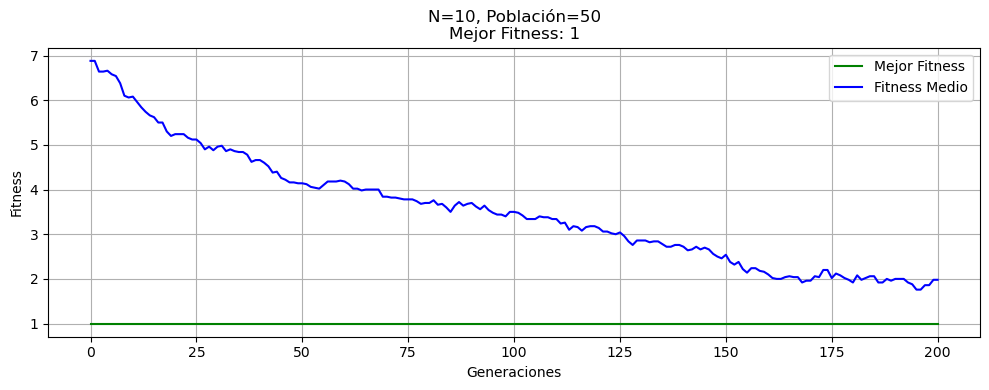

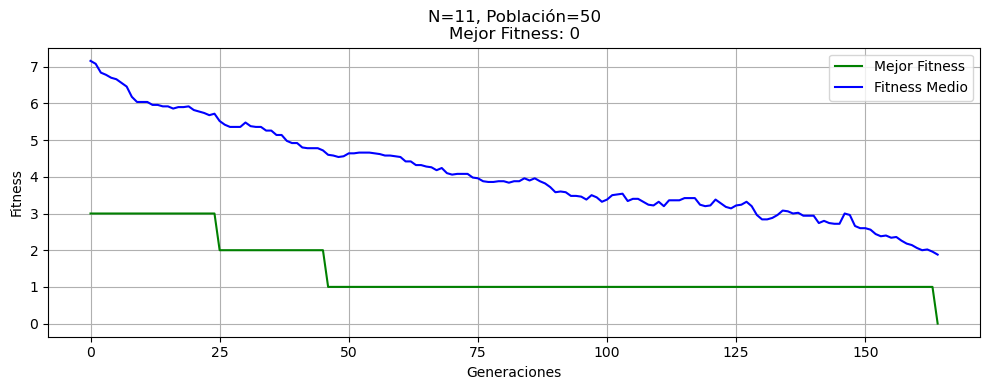

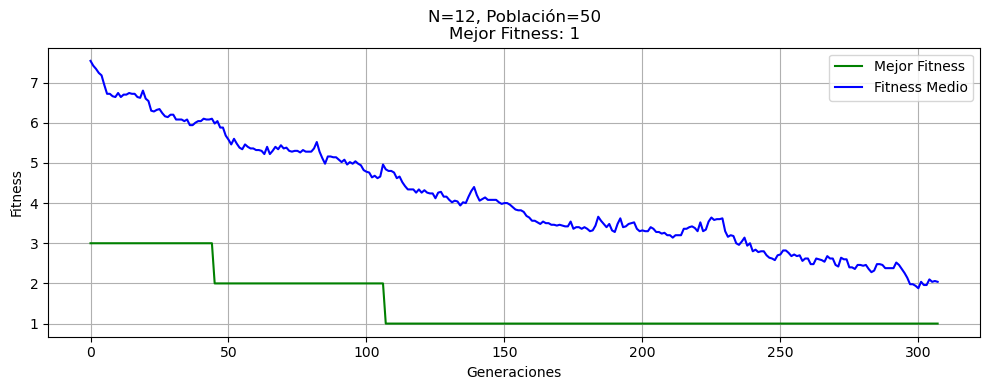

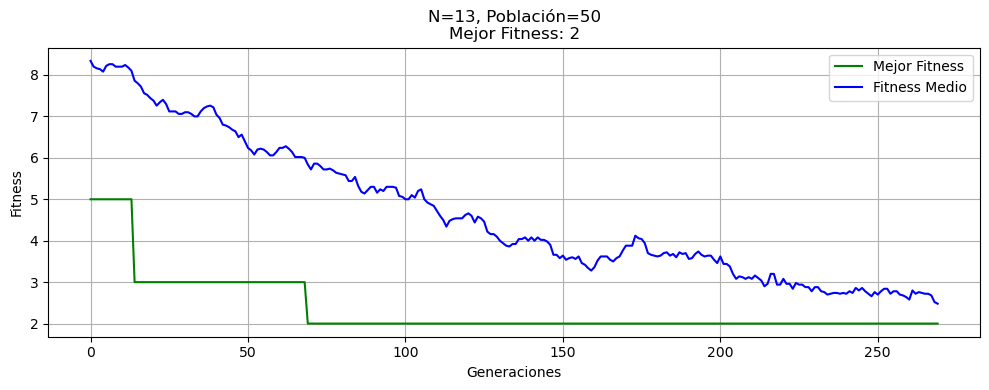

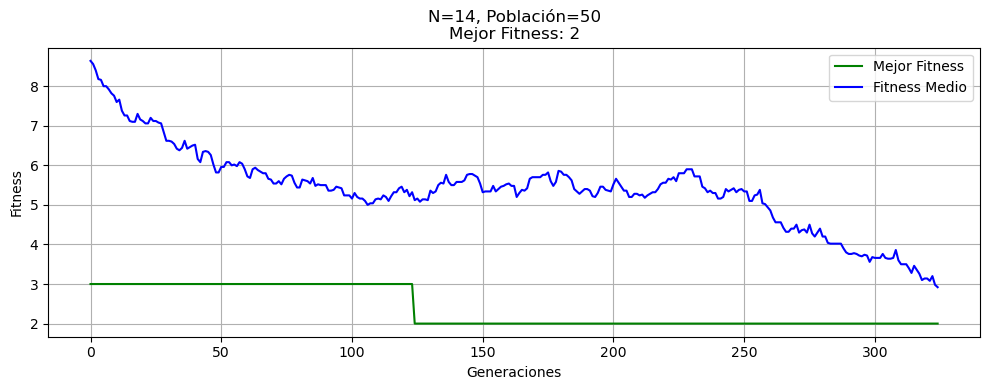

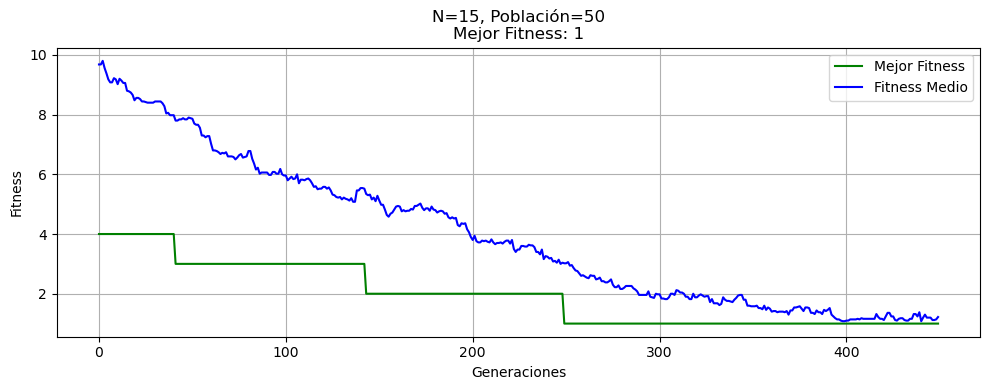

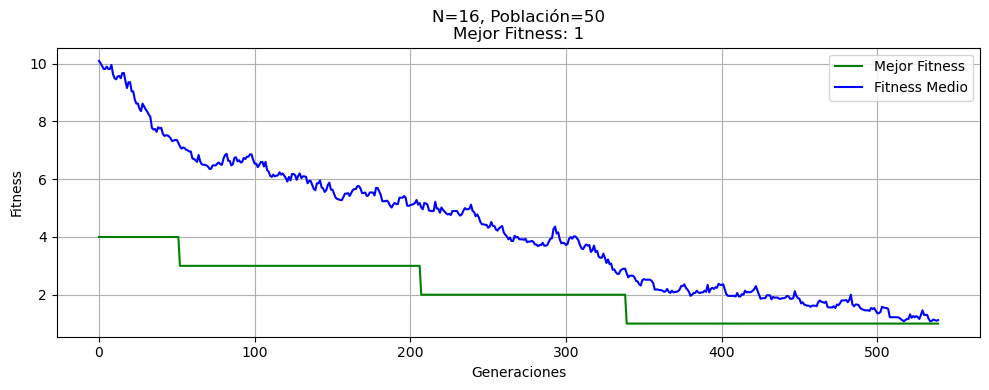

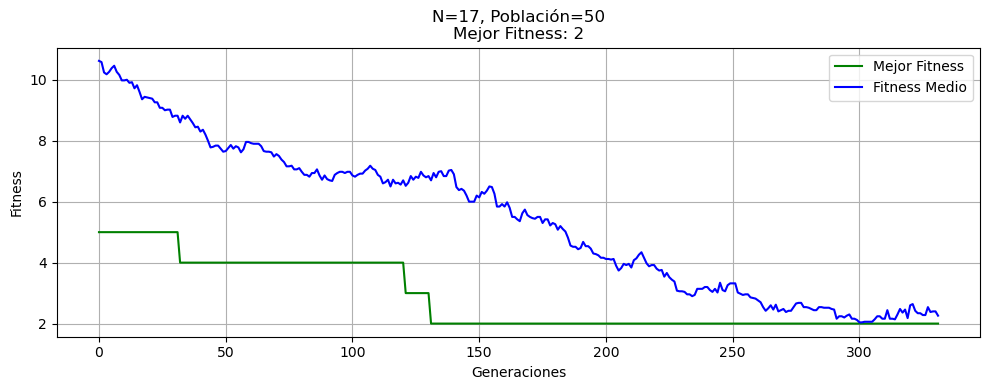

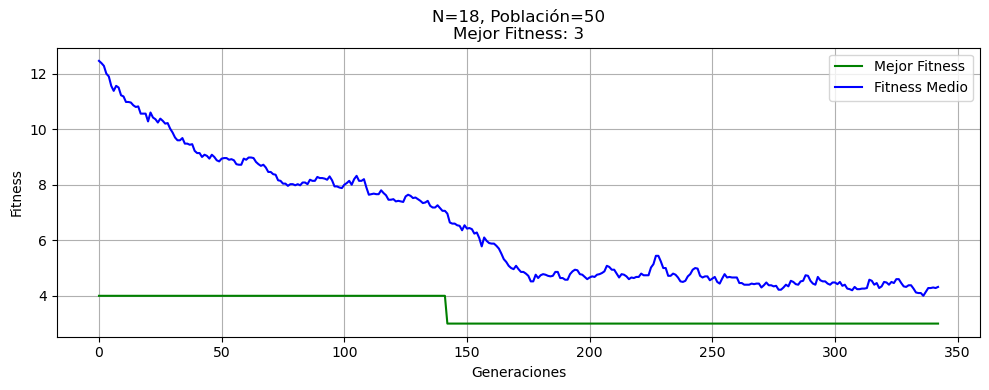

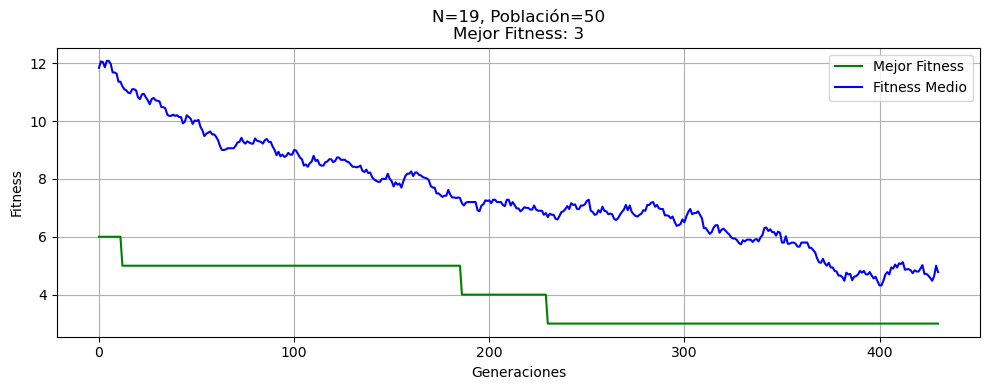

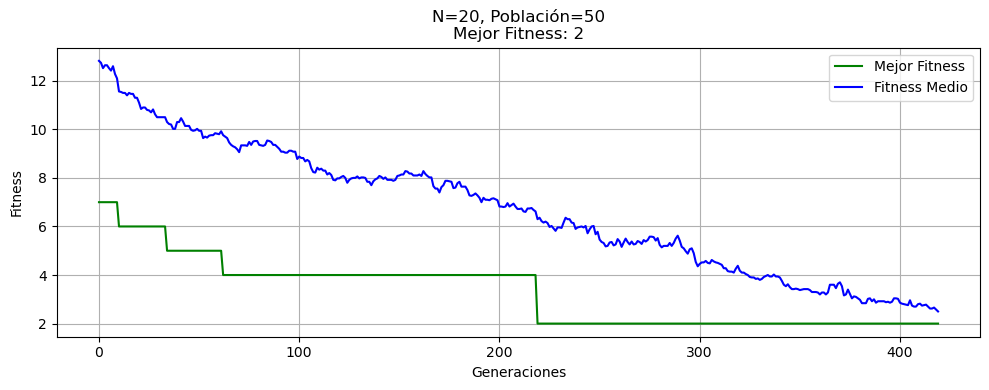

In [17]:
N = 20
N_poblacion = 50
num_iteraciones = 500
num_ejecuciones = 3

for n in range(4, N+1):
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=n,
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200)

    fig, ax = plt.subplots(figsize=(10, 4))
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, N_reinas=n, tam_poblacion=N_poblacion, ax=ax)
    plt.tight_layout()
    plt.show()    

Podemos ver que por lo general, cuando N <= 9, el problema se resuelve correctamente. Sin embargo, en cuanto N > 9 el problema no llega en su mayor√≠a de veces a la soluci√≥n. 

En los casos en los que no se llega a la soluci√≥n, pueden estar ocurriendo varias cosas:

- La poblaci√≥n es dominada por un m√≠nimo local.
- La poblaci√≥n no es suficientemente grande variada (poca presi√≥n evolutiva), y la convergencia es muy lenta.

## 2. Variaci√≥n en el tama√±o de la poblaci√≥n:

Para ver que es lo que pasa, nos centraremos en el problema con N = 20, y probaremos a ejecutar el algoritmo con distitos distintos tama√±os de poblaci√≥n:

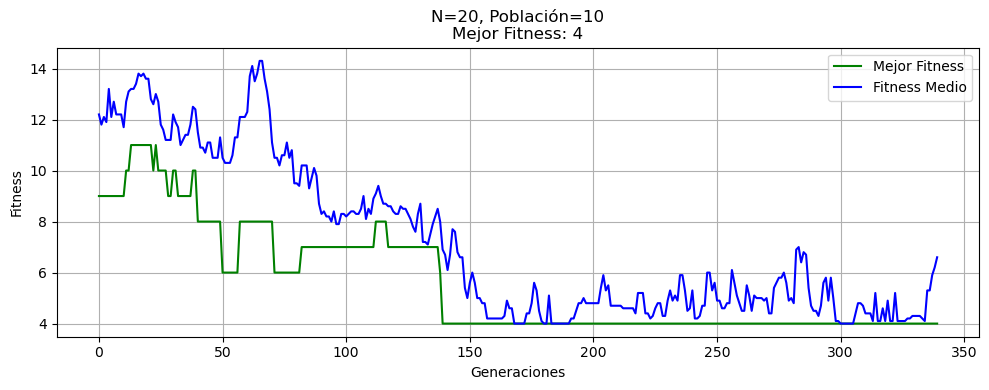

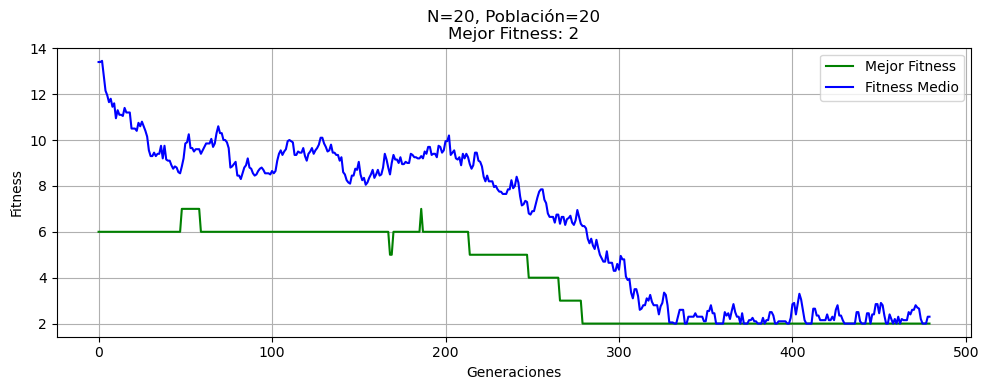

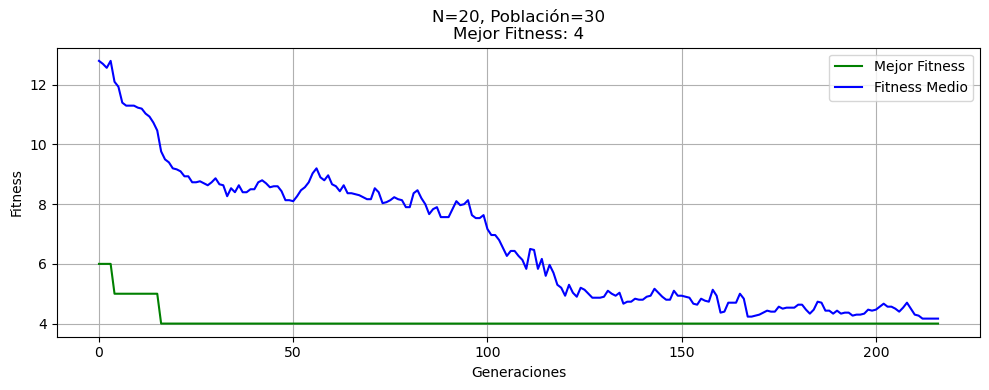

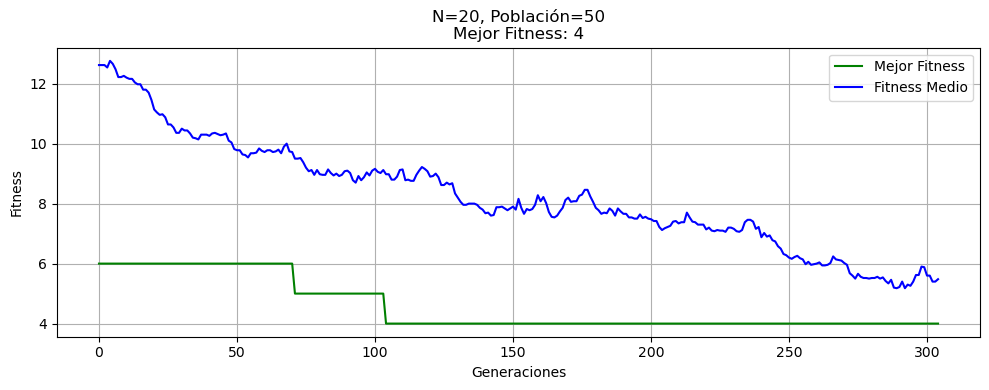

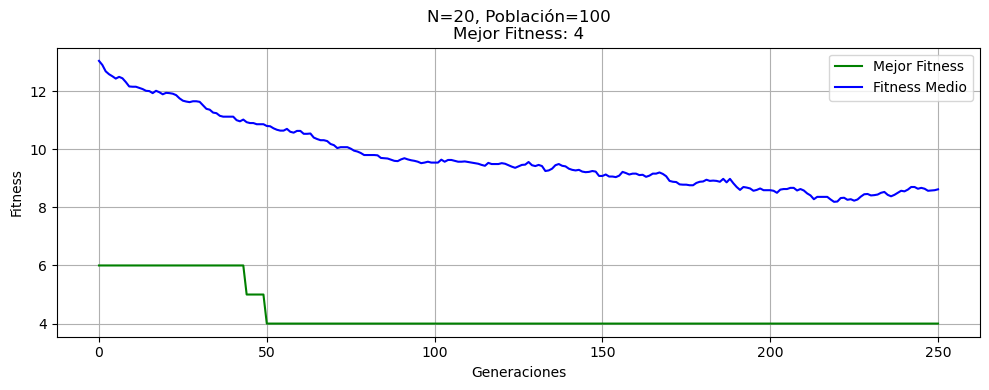

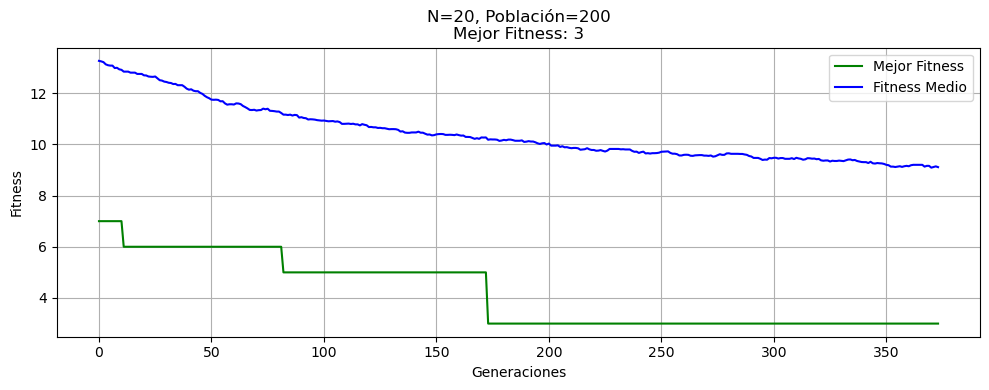

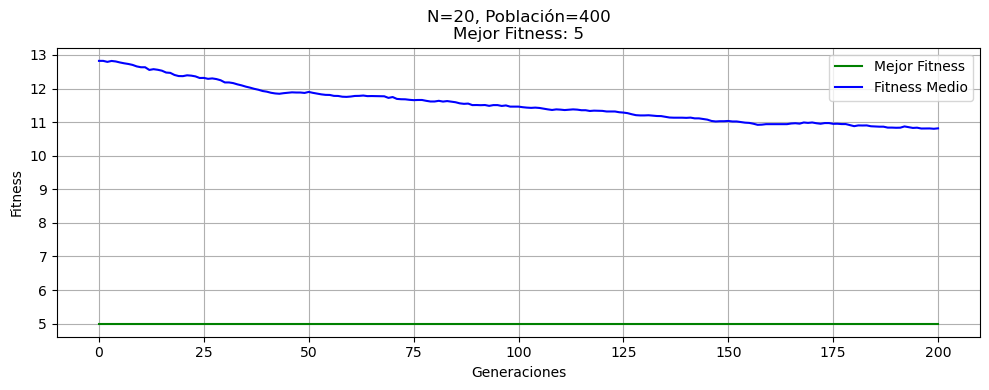

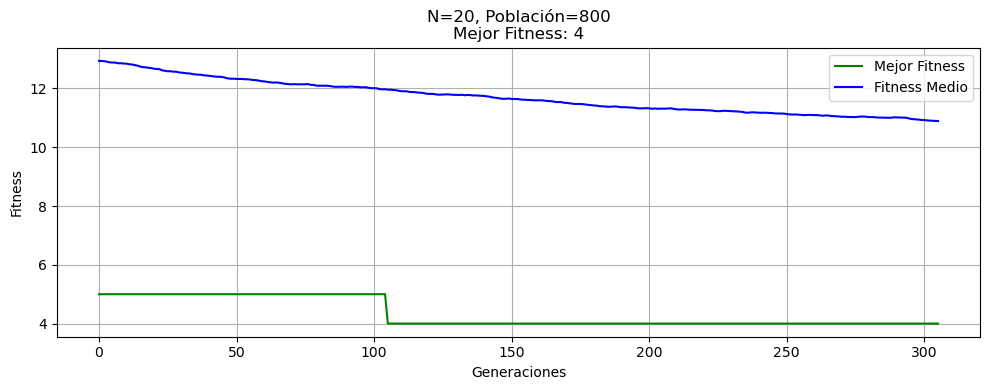

In [18]:
N_reinas = 20
N_poblaciones = [10, 20, 30, 50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=200
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, N_reinas=N_reinas, tam_poblacion=N_poblacion, ax=ax)
    plt.tight_layout()
    plt.show()   

Se observa que, cuando el tama√±o de la poblaci√≥n es peque√±o, el algoritmo tiende a converger hacia un √≥ptimo local. Esto probablemente se deba a que, en poblaciones reducidas, resulta m√°s f√°cil que un esquema dominante se imponga sobre el resto de la poblaci√≥n.

Por otro lado, al aumentar el tama√±o de la poblaci√≥n, el algoritmo parece converger de forma m√°s lenta. Esto podr√≠a deberse a una menor presi√≥n evolutiva. Para verificar esta hip√≥tesis, repetiremos la prueba utilizando un n√∫mero m√°ximo de generaciones sin mejora igual a 1000.

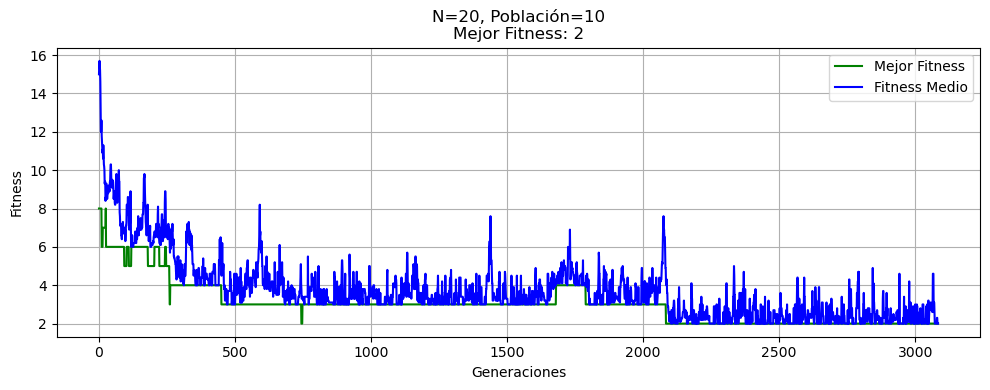

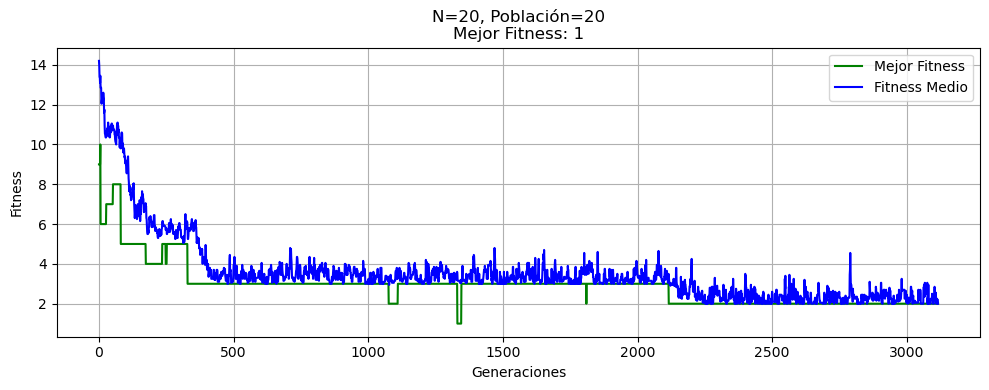

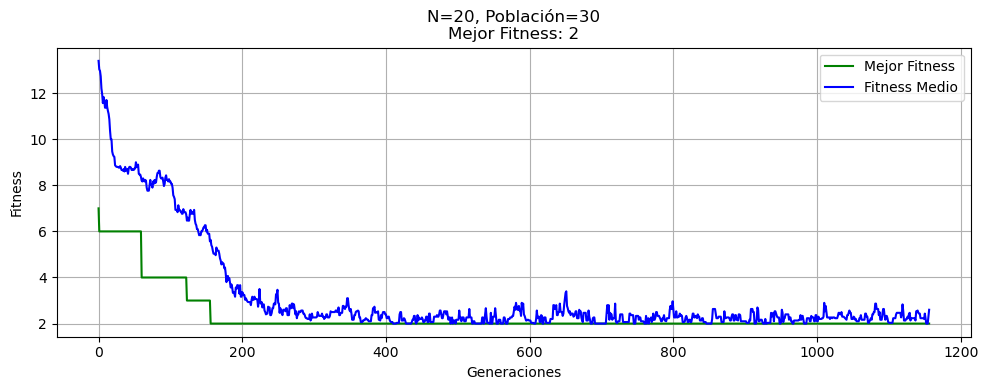

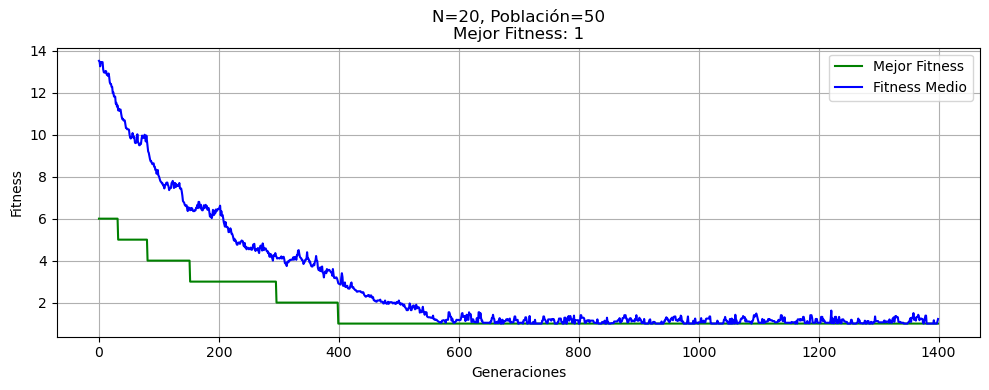

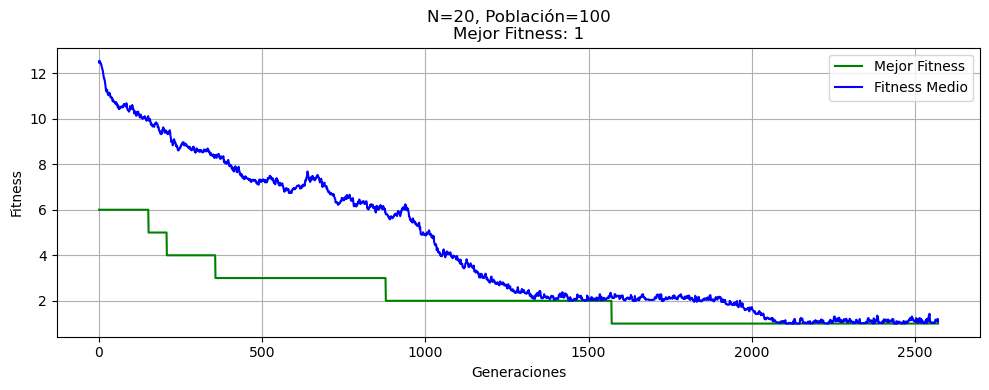

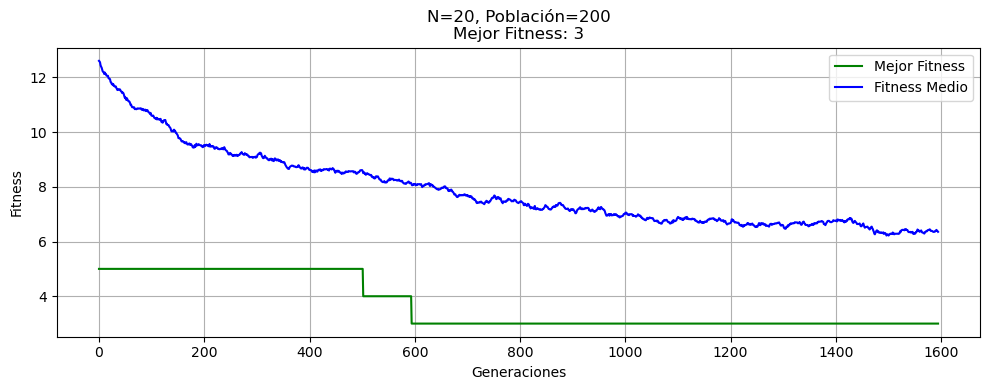

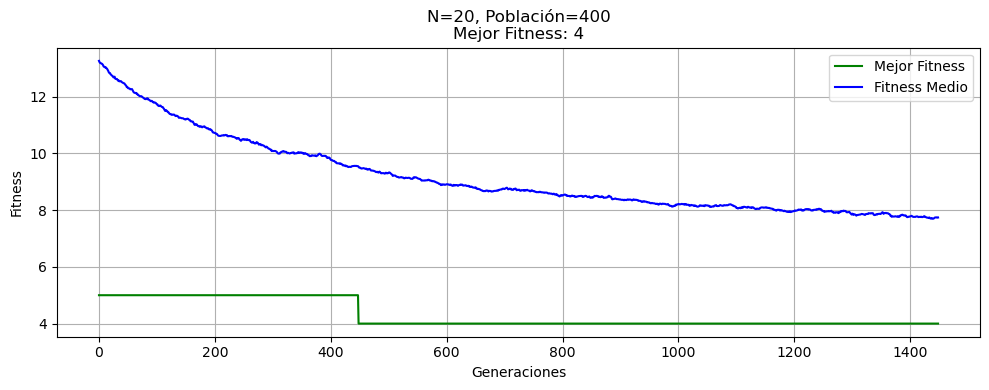

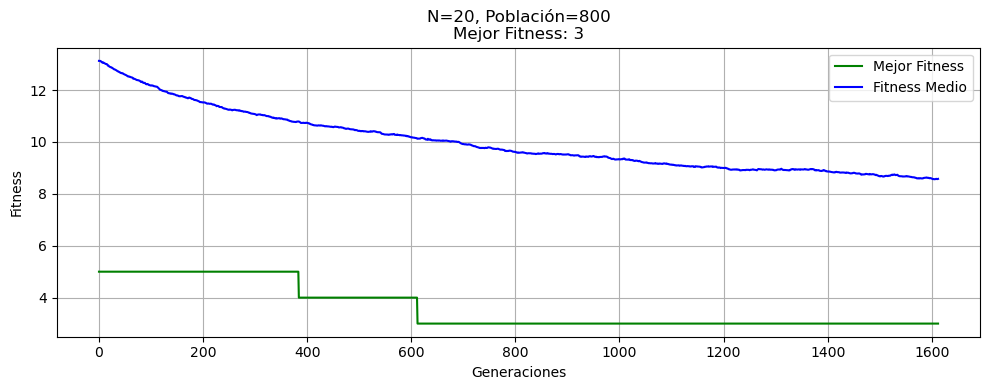

In [19]:
N_reinas = 20
N_poblaciones = [10, 20, 30, 50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, N_reinas=N_reinas, tam_poblacion=N_poblacion, ax=ax)
    plt.tight_layout()
    plt.show()   

Con esta prueba, podemos concluir que, en este caso, incrementar el n√∫mero de iteraciones no resulta efectivo para resolver el problema. Esto se debe a que la principal dificultad radica en una presi√≥n evolutiva insuficiente, lo que provoca que el algoritmo gen√©tico tienda a estancarse en √≥ptimos locales o a converger de forma muy lenta hacia una soluci√≥n adecuada.

## 3. Generaci√≥n de m√°s descendientes

Con el objetivo de abordar el problema de la baja presi√≥n evolutiva, intentaremos generar una mayor cantidad de descendientes. Esto permitir√° incrementar la diversidad dentro de la poblaci√≥n y aumentar√° la probabilidad de que alguno de los individuos se acerque a una soluci√≥n √≥ptima. Para ello, se aplicar√°n las siguientes estrategias:

- Se seleccionar√° al **40% de la poblaci√≥n** como progenitores.  
- Los progenitores se emparejar√°n de **dos en dos**, y se aplicar√° **cruce en el 90%** de los casos.  
- El **30% de los descendientes** generados ser√°n sometidos a **mutaci√≥n**.


In [20]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo gen√©tico para resolver el problema de las N-reinas.

    :param N_poblacion: N√∫mero de individuos en la poblaci√≥n.
    :param N_cromosoma: Tama√±o del cromosoma (N del problema).
    :param f_fitness: Funci√≥n de evaluaci√≥n de fitness.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutaci√≥n.
    :param num_iteraciones: N√∫mero de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evoluci√≥n del fitness por generaci√≥n, y 
        la evoluci√≥n del fitness medio por generaci√≥n.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    iteraciones = 0
    while(True):    
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)

        # Si hemos alcanzado una soluci√≥n, finalizamos
        if np.min(poblacion.fitness_poblacion) == 0:
            break
        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = mutar_individuo_sacudida(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = mutar_individuo_sacudida(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Para probar el nuevo algoritmo, lo ejecutaremos varias veces con distintos tama√±os de poblaci√≥n. Cada una de las configuraciones la ejecutaremos varias veces para medir la tasa de exito. 

Definimos una funci√≥n para medir el rendimiento:

Ejecutamos la prueba:

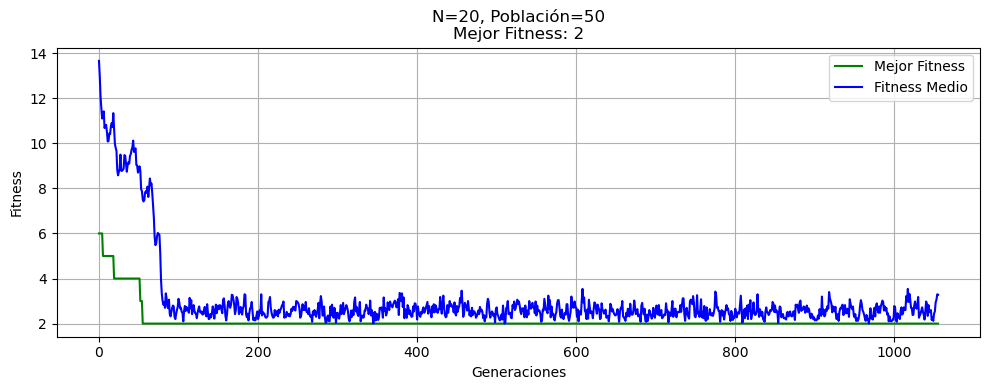

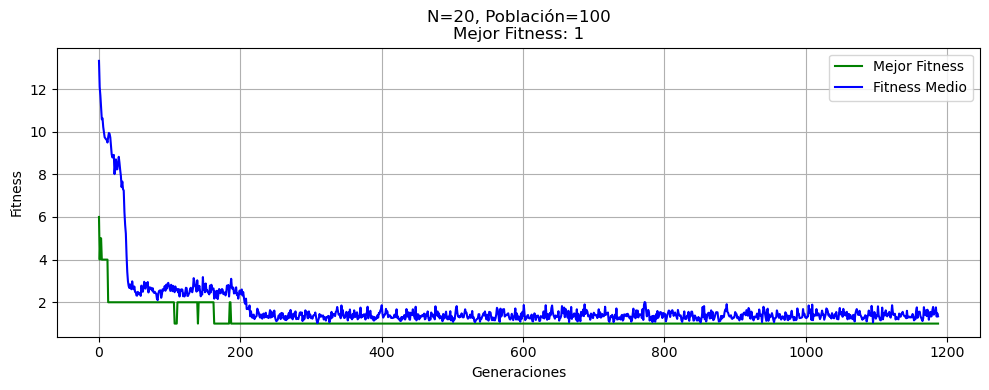

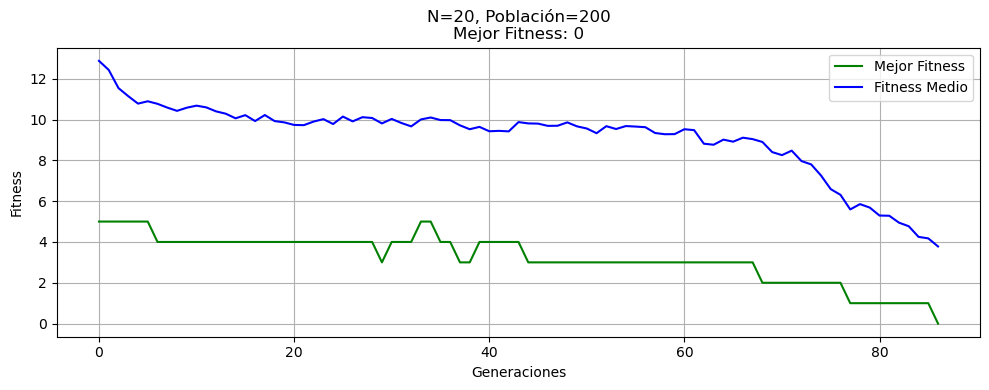

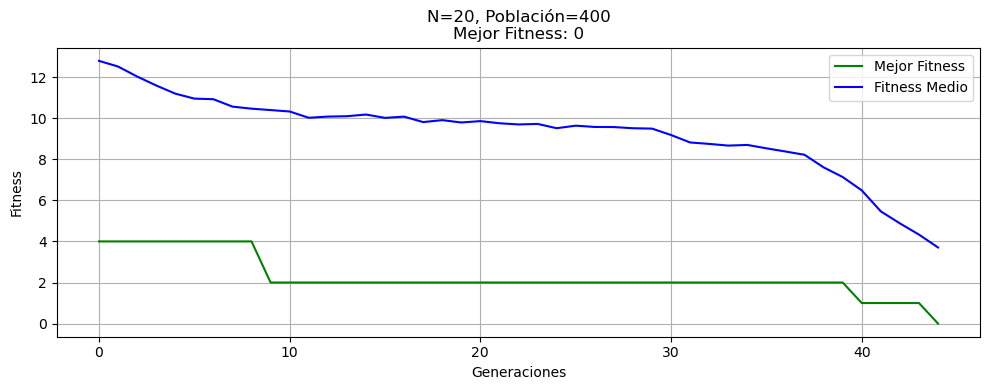

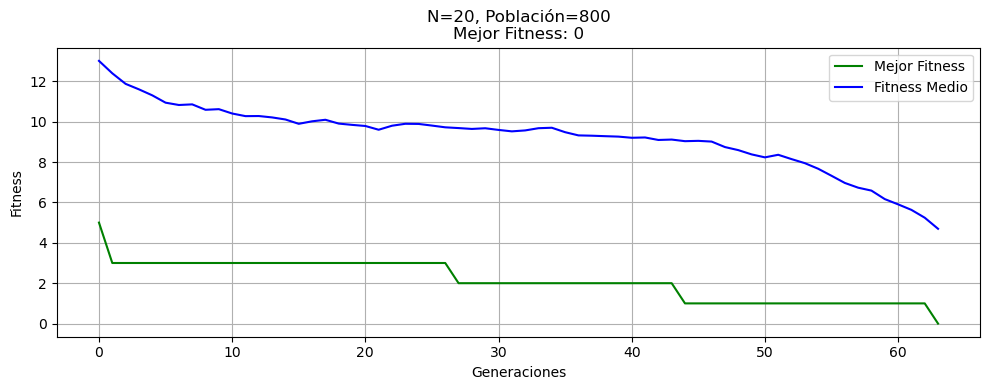

In [21]:
N_reinas = 20
N_poblaciones = [50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, N_reinas=N_reinas, tam_poblacion=N_poblacion, ax=ax)
    plt.tight_layout()
    plt.show()  

Al aumentar la cantidad de descendientes generados en cada generaci√≥n, se incrementa la presi√≥n evolutiva, lo que permite al algoritmo gen√©tico encontrar soluciones al problema de las 20 reinas. Este ajuste favorece una exploraci√≥n m√°s eficiente del espacio de b√∫squeda, mientras que una alta tasa de cruzamiento, combinada con una mutaci√≥n equilibrada, contribuye a mantener una diversidad gen√©tica adecuada y a prevenir la convergencia prematura.

Los resultados muestran que, a partir de una poblaci√≥n de 400 individuos, el algoritmo consigue hallar una soluci√≥n. No obstante, en la mayor√≠a de los tama√±os de poblaci√≥n evaluados, se observan a√∫n muchas generaciones sin mejora del mejor individuo, lo que evidencia que la presi√≥n evolutiva sigue siendo insuficiente. En particular, cuando la poblaci√≥n es menor a 400, el algoritmo tiende a converger prematuramente hacia √≥ptimos locales.

Adem√°s, el aumento en la cantidad de descendientes por generaci√≥n conlleva un mayor coste computacional por iteraci√≥n. Por ello, no resulta conveniente utilizar poblaciones excesivamente grandes ni prolongar innecesariamente el n√∫mero de generaciones, ya que esto compromete la eficiencia del algoritmo.

## 4. Escalamiento sigma de Goldberg:

Para tratar de solucionar el problema de la convergencia prematura, se aplicar√° el **escalamiento sigma de Goldberg** en el proceso de selecci√≥n de progenitores y supervivientes. Esta t√©cnica ajusta los valores de aptitud (fitness) para mantener una presi√≥n selectiva adecuada a lo largo de las generaciones, evitando que unos pocos individuos dominen la poblaci√≥n demasiado pronto.

La f√≥rmula del escalamiento sigma es la siguiente:

$$
f'_i = \max \left( f_i - (\bar{f} - c \cdot \sigma_f), \ 0 \right)
$$

donde:

- $f'_i$ es el fitness escalado del individuo $i$  
- $f_i$ es el fitness original del individuo $i$  
- $\bar{f}$ es el fitness promedio de la poblaci√≥n  
- $\sigma_f$ es la desviaci√≥n est√°ndar del fitness en la poblaci√≥n  
- $c$ es la constante de control (cogeremos $c = 2$)

Este m√©todo permite conservar la diversidad gen√©tica por m√°s tiempo, al reducir la presi√≥n selectiva cuando las diferencias entre los individuos son peque√±as.

Primero crearemos una funci√≥n que calcule el escalamiento sigma los individuos de una poblaci√≥n:

In [22]:
def escalamiento_sigma(poblacion):
    fitness_poblacion = poblacion.fitness_poblacion

    # Calculamos los estad√≠sticos necesarios
    mean = np.mean(fitness_poblacion)
    std = np.std(fitness_poblacion)

    # Calculamos el fitness escalado
    fitness_escalado = [np.max([f_i - (mean - 2*std), 0]) for f_i in fitness_poblacion]

    return fitness_escalado

Modificamos la funci√≥n de selecci√≥n de progenitores:

In [23]:
def seleccionar_progenitores_ruleta(poblacion: 'Poblacion', N_progenitores: int) -> List['Individuo']:
    """
    Selecciona un n√∫mero de progenitores de la poblaci√≥n utilizando el m√©todo de la ruleta,
    donde los individuos con mejor fitness (fitness m√°s bajo) tienen mayor probabilidad de ser seleccionados.
    La selecci√≥n es sin reemplazo, lo que evita que un individuo sea seleccionado m√°s de una vez.

    :param poblacion: La poblaci√≥n de individuos de la cual se seleccionan los progenitores.
    :param N_progenitores: El n√∫mero de progenitores que se desean seleccionar.
    :return: Una lista de progenitores seleccionados.
    """
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_escalado = escalamiento_sigma(poblacion)
    fitness_invertido = 1 / (1 + np.array(fitness_escalado))

    # Seleccionamos los progenitores sin reemplazo
    progenitores_indices = np.random.choice(len(poblacion.individuos), size=N_progenitores, replace=False, p=fitness_invertido / np.sum(fitness_invertido))
    
    progenitores = [poblacion.individuos[i] for i in progenitores_indices]

    return progenitores

Modificamos la funci√≥n de selecci√≥n de supervivientes:

In [24]:
def seleccionar_supervivientes_ruleta(poblacion: 'Poblacion', descendientes: List['Individuo']) -> 'Poblacion':
    """
    Selecciona a los mejores individuos de la poblaci√≥n actual y los descendientes utilizando el m√©todo de la ruleta.
    Los individuos con mejor fitness (fitness m√°s bajo) tienen mayor probabilidad de ser seleccionados.

    :param poblacion: Objeto de la clase Poblacion que representa la poblaci√≥n actual.
    :param descendientes: Lista de individuos generados en la √∫ltima generaci√≥n (descendientes).
    :return: Nueva poblaci√≥n formada por los mejores individuos seleccionados.
    """
    # Agregamos los descendientes a la poblaci√≥n actual
    individuos = poblacion.individuos + descendientes
    f_fitness = individuos[0].f_fitness
    # Creamos la poblaci√≥n sin eliminaciones
    poblacion_nueva = Poblacion(
        N_poblacion=poblacion.N_poblacion,
        N_cromosoma=poblacion.N_cromosoma,
        f_fitness=f_fitness,
        individuos=individuos
    )
    
    # Obtenemos los fitness de todos los individuos
    fitness_escalado = escalamiento_sigma(poblacion_nueva)
    
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + np.array(fitness_escalado))  # Sumamos 1 para evitar divisi√≥n por 0
    
    # Normalizamos las probabilidades
    probabilidades = fitness_invertido / np.sum(fitness_invertido)
    
    # Seleccionamos los supervivientes (mismo tama√±o que la poblaci√≥n original)
    supervivientes_indices = np.random.choice(len(individuos), size=poblacion.N_poblacion, replace=False, p=probabilidades)
    
    supervivientes = [individuos[i] for i in supervivientes_indices]
    
    # Creamos una nueva poblaci√≥n con los mejores individuos seleccionados
    poblacion_superviviente = Poblacion(
        N_poblacion=poblacion.N_poblacion,
        N_cromosoma=poblacion.N_cromosoma,
        f_fitness=f_fitness,
        individuos=supervivientes
    )
    
    return poblacion_superviviente

Ejecutamos la prueba de antes pero con el escalamiento:

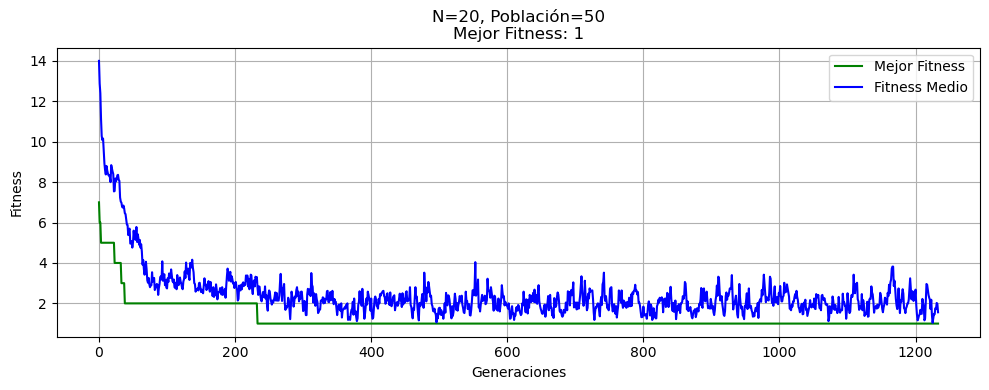

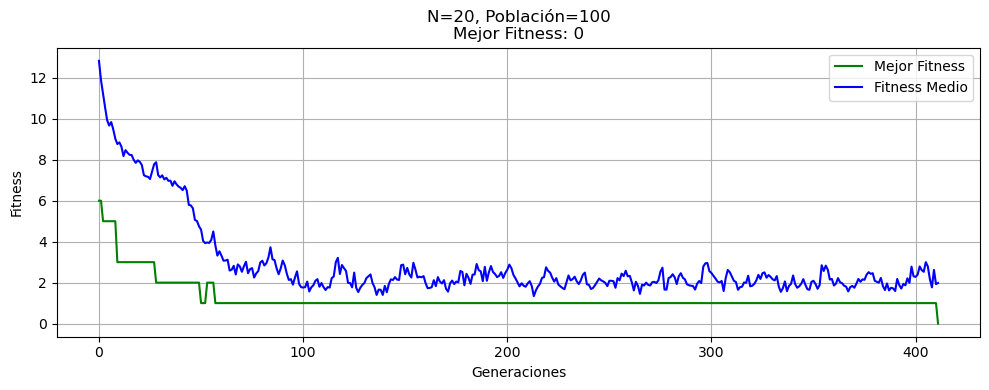

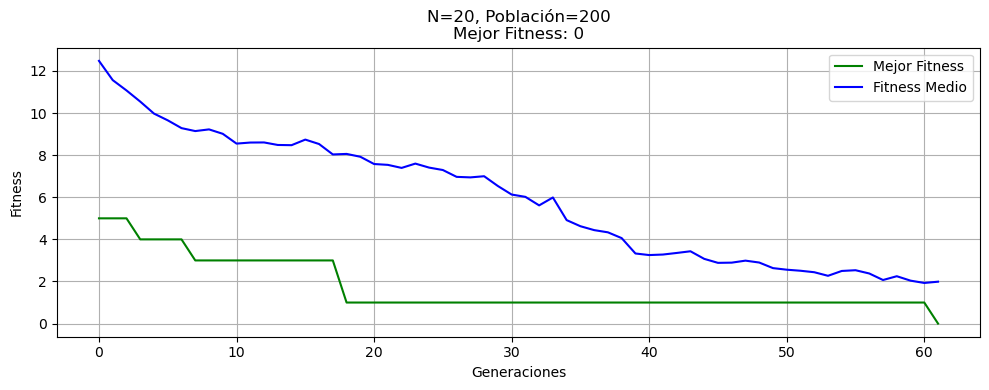

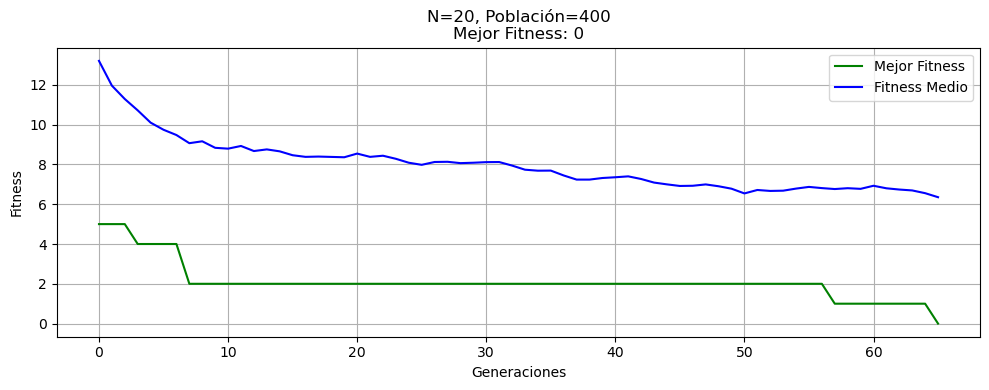

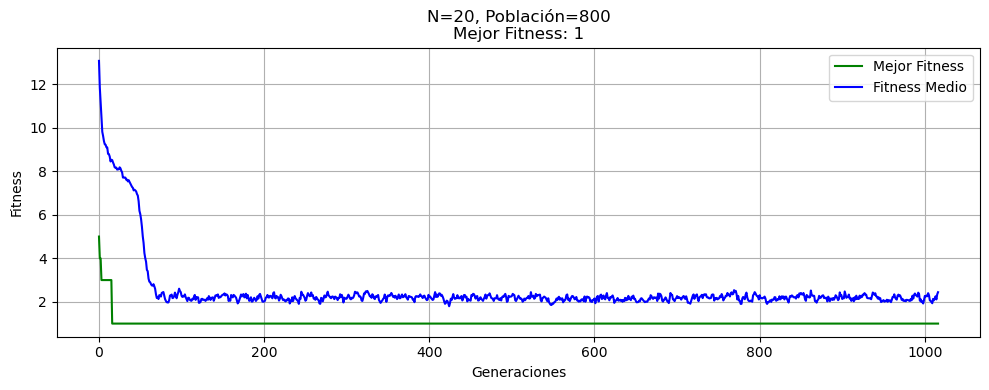

In [25]:
N_reinas = 20
N_poblaciones = [50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N_reinas,  
        f_fitness=fitness,
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    crear_grafico_fitness(mejor_fitness_generacion, fitness_medio_generacion, N_reinas=N_reinas, tam_poblacion=N_poblacion, ax=ax)
    plt.tight_layout()
    plt.show()  

En este caso, podemos observar un comportamiento caracter√≠stico de la convergencia prematura. Cuando el tama√±o de la poblaci√≥n es menor a 400, el algoritmo logra encontrar una soluci√≥n, pero requiere muchas generaciones para hacerlo, lo que indica que queda atrapado temporalmente en √≥ptimos locales. A pesar de ello, si analizamos la distancia entre las curvas de fitness medio y del mejor fitness, se puede apreciar una mayor diversidad en la poblaci√≥n en comparaci√≥n con la prueba anterior.

Esto sugiere que el uso del escalamiento sigma est√° siendo beneficioso, ya que contribuye a mantener la diversidad gen√©tica durante m√°s generaciones. En particular, cuando el tama√±o poblacional es igual o superior a 400, el efecto del escalamiento es m√°s notable: el algoritmo no solo evita la convergencia prematura, sino que tambi√©n logra alcanzar soluciones √≥ptimas en menos generaciones.

## 5. Efecto de los distintos tipos de mutaci√≥n:

La mutaci√≥n desempe√±a un papel fundamental en los algoritmos gen√©ticos. Cuando el algoritmo queda atrapado en un √≥ptimo local, la mutaci√≥n se convierte en un mecanismo esencial para introducir variaci√≥n en los descendientes, permitiendo as√≠ escapar de esos m√≠nimos y acercarse progresivamente a una soluci√≥n √≥ptima.

Para evaluar su impacto en el rendimiento del algoritmo, probaremos diferentes enfoques de mutaci√≥n en los cromosomas. El objetivo es identificar qu√© m√©todo favorece una mejora m√°s r√°pida del mejor fitness por generaci√≥n y, en consecuencia, acelera la convergencia del algoritmo. Estos son las t√©cnicas de mutaci√≥n que utilizaremos:

- Mutaci√≥n por sacudida (actual)
- Mutaci√≥n por intercambio
- Mutaci√≥n por inserci√≥n
- Mutaci√≥n por inversi√≥n

Para poder realizar las pruebas, primero modificaremos el algoritmo gen√©tico, de tal manera que se pueda elegir la funci√≥n de mutaci√≥n a utilizar:

In [57]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       f_mutacion: Callable[['Individuo'], 'Individuo'],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       max_sin_mejoras: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo gen√©tico para resolver el problema de las N-reinas.

    :param N_poblacion: N√∫mero de individuos en la poblaci√≥n.
    :param N_cromosoma: Tama√±o del cromosoma (N del problema).
    :param f_fitness: Funci√≥n de evaluaci√≥n de fitness.
    :param f_mutacion: Funci√≥n de mutaci√≥n de los cromosomas.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutaci√≥n.
    :param max_sin_mejoras: N√∫mero de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evoluci√≥n del fitness por generaci√≥n, y 
        la evoluci√≥n del fitness medio por generaci√≥n.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    iteraciones = 0
    while(True):   
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)
        
        if np.min(poblacion.fitness_poblacion) == 0:
            break

        # Si llevamos max_sin_mejoras generaciones sin mejoras, finalizamos
        if iteraciones >= max_sin_mejoras:
            if all(x == mejor_fitness_generacion[iteraciones] for x in mejor_fitness_generacion[iteraciones-max_sin_mejoras : iteraciones+max_sin_mejoras]):
                break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = f_mutacion(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = f_mutacion(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

        iteraciones += 1

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

### 5.1. Mutaci√≥n por intercambio:

Creamos la funci√≥n encargada de mutar por intercambio:

In [58]:
def mutar_individuo_intercambio(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutaci√≥n por intercambio a un cromosoma.
    Se seleccionan 2 genes aleatorios y se intercambian.

    :param cromosoma: Cromosoma original (permutaci√≥n de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos √≠ndices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Intercambiamos las posiciones
    mutado[i], mutado[j] = mutado[j], mutado[i] 

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

In [ ]:
N = 20
N_poblaciones = [50, 100, 200, 400, 800]

for N_poblacion in N_poblaciones:
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,  
        f_fitness=fitness,
        f_mutacion=
        prob_cruz=0.9,
        prob_mut=0.3,
        max_sin_mejoras=1000
    )

    print(f"Resolviendo el problema de las {N}-reinas:")
    print(f"Tama√±o de la poblaci√≥n: {N_poblacion}")
    print(f"Fitness final: {mejor_fitness}")
    mejor_solucion.mostrar_individuo()
    mostrar_historial_fitness(mejor_fitness_generacion, fitness_medio_generacion)

Creamos la funci√≥n encargada de mutar por inserci√≥n:

In [ ]:
def mutar_individuo_insercion(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutaci√≥n por inserci√≥n a un cromosoma.
    Se seleccionan dos posiciones aleatorias y el gen en la segunda posici√≥n se inserta en la primera.

    :param cromosoma: Cromosoma original (permutaci√≥n de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos √≠ndices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Realizamos la inserci√≥n
    elemento = mutado.pop(j) 
    mutado.insert(i, elemento) 

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

Creamos la funci√≥n encargada de mutar por inversi√≥n:

In [ ]:
def mutar_individuo_inversion(individuo: 'Individuo') -> 'Individuo':
    """
    Aplica la mutaci√≥n por inversi√≥n a un cromosoma.
    Se seleccionan dos posiciones aleatorias y se invierten los genes entre esas dos posiciones.

    :param cromosoma: Cromosoma original (permutaci√≥n de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos √≠ndices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Realizamos la inversi√≥n
    mutado[i:j+1] = reversed(mutado[i:j+1])

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

Modificamos el algoritmo gen√©tico para poder elegir la mutaci√≥n:

In [55]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       f_mutacion: Callable[['Individuo'], 'Individuo'],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       num_iteraciones: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo gen√©tico para resolver el problema de las N-reinas.

    :param N_poblacion: N√∫mero de individuos en la poblaci√≥n.
    :param N_cromosoma: Tama√±o del cromosoma (N del problema).
    :param f_fitness: Funci√≥n de evaluaci√≥n de fitness.
    :param f_mutacion: Funci√≥n de mutaci√≥n de los cromosomas.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutaci√≥n.
    :param num_iteraciones: N√∫mero de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evoluci√≥n del fitness por generaci√≥n, y 
        la evoluci√≥n del fitness medio por generaci√≥n.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    for i in range(num_iteraciones):    
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)
        
        if np.min(poblacion.fitness_poblacion) == 0:
            break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = cruzar_progenitores_pmx(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = f_mutacion(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = cruzar_progenitores_pmx(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = f_mutacion(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_supervivientes_ruleta(poblacion=poblacion, descendientes=descendientes)

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Tras realizar las pruebas, queda claro que la mutaci√≥n por intercambio es la m√°s eficaz para resolver el problema de las N-reinas. No solo alcanza una tasa de √©xito del 100%, sino que adem√°s lo hace con el mejor tiempo promedio entre todas las estrategias evaluadas.

Este resultado tiene sentido si analizamos la naturaleza del problema. Una soluci√≥n v√°lida consiste en una permutaci√≥n del vector de columnas, donde ninguna reina se ataca con otra. A menudo, cuando el algoritmo se acerca a una soluci√≥n, solo es necesario intercambiar la posici√≥n de dos reinas para corregir los √∫ltimos conflictos. La mutaci√≥n por intercambio permite precisamente ese tipo de ajustes locales de forma directa, mientras que otras mutaciones (como la inversi√≥n o la inserci√≥n) pueden alterar tramos enteros del cromosoma y romper soluciones parciales correctas.

En contraste, al emplear la mutaci√≥n por sacudida ‚Äîutilizada en pruebas anteriores‚Äî, la tasa de √©xito se reduce dr√°sticamente, del 100% al 50%. Esto se debe a que la sacudida modifica el cromosoma de forma m√°s aleatoria y disruptiva, lo cual puede ayudar a escapar de √≥ptimos locales, pero tambi√©n dificulta refinar soluciones prometedoras.

Esta diferencia ilustra bien la naturaleza estoc√°stica de los algoritmos gen√©ticos: peque√±os cambios en los operadores pueden tener un impacto notable en la convergencia del algoritmo y su capacidad de explorar el espacio de b√∫squeda de forma efectiva.

Para observar mejor el comportamiento de la mutaci√≥n por intercambio, analizaremos algunas gr√°ficas que muestrem la evoluci√≥n del fitness promedio y del mejor fitness por generaci√≥n. Esto nos permitir√° entender c√≥mo progresa la poblaci√≥n hacia soluciones √≥ptimas a lo largo del tiempo.


--- Repetici√≥n 1 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [12, 3, 13, 4, 9, 5, 15, 2, 14, 17, 9, 18, 16, 10, 4, 1, 19, 0, 16, 11]
Fitness: 0


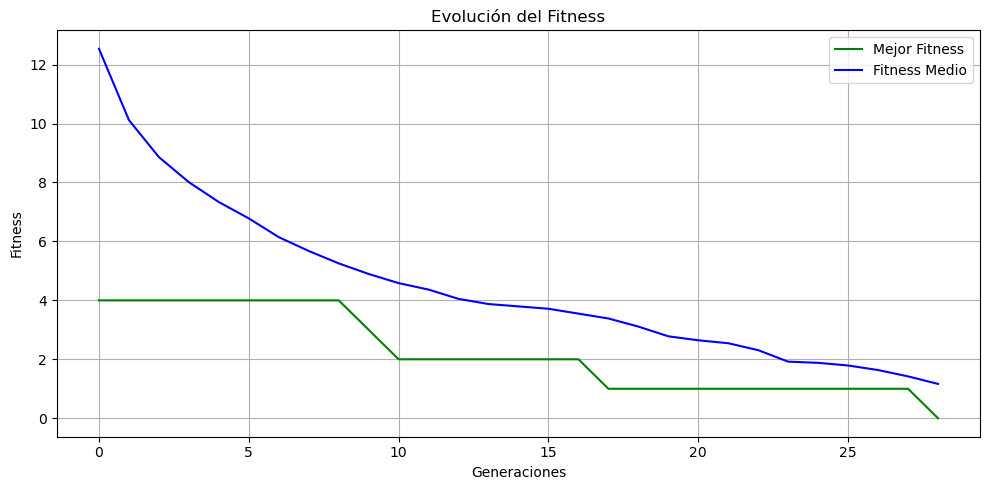


--- Repetici√≥n 2 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [7, 18, 13, 2, 9, 3, 15, 17, 3, 13, 6, 19, 14, 1, 11, 16, 19, 0, 18, 10]
Fitness: 0


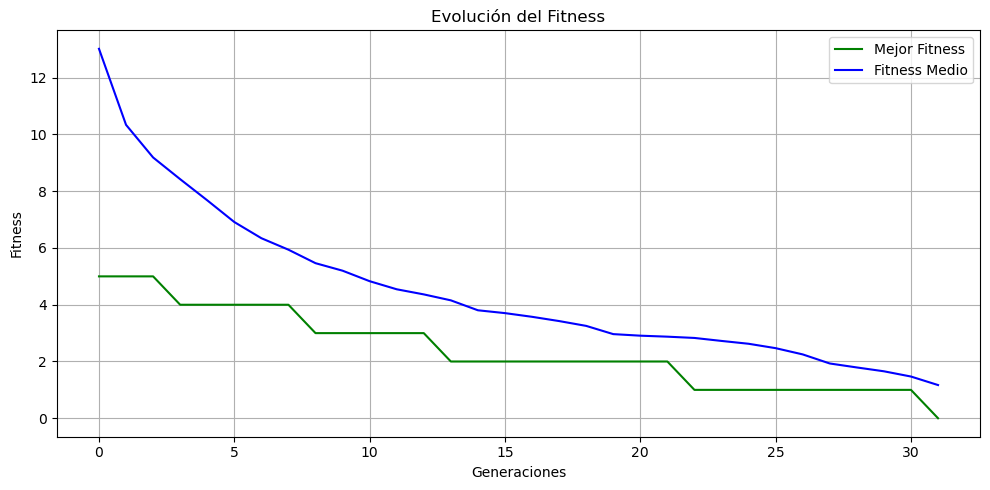


--- Repetici√≥n 3 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [2, 6, 15, 11, 14, 0, 3, 8, 17, 2, 0, 18, 4, 9, 12, 19, 7, 16, 1, 5]
Fitness: 0


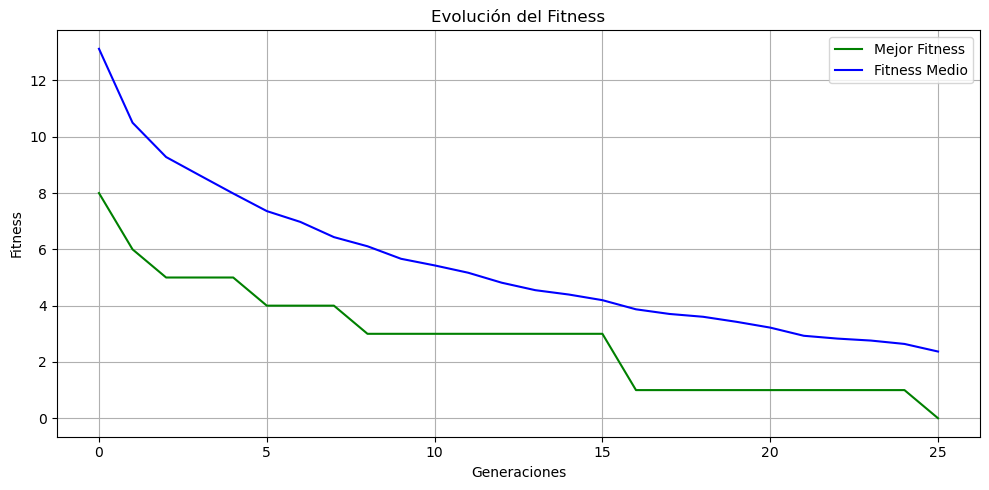


--- Repetici√≥n 4 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [3, 1, 6, 9, 12, 15, 11, 16, 19, 1, 9, 7, 14, 2, 0, 13, 17, 8, 12, 16]
Fitness: 0


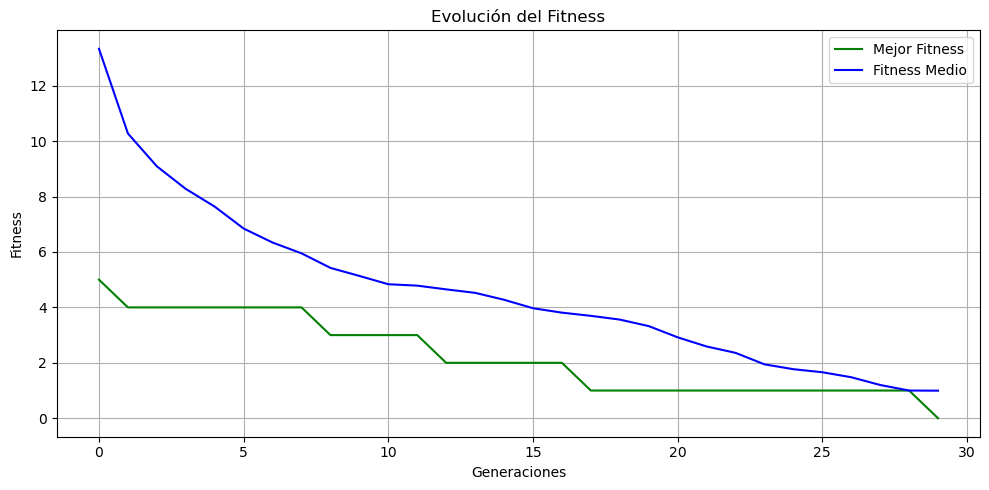


--- Repetici√≥n 5 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [8, 11, 13, 17, 9, 0, 4, 10, 1, 18, 12, 7, 16, 19, 2, 15, 3, 6, 15, 5]
Fitness: 0


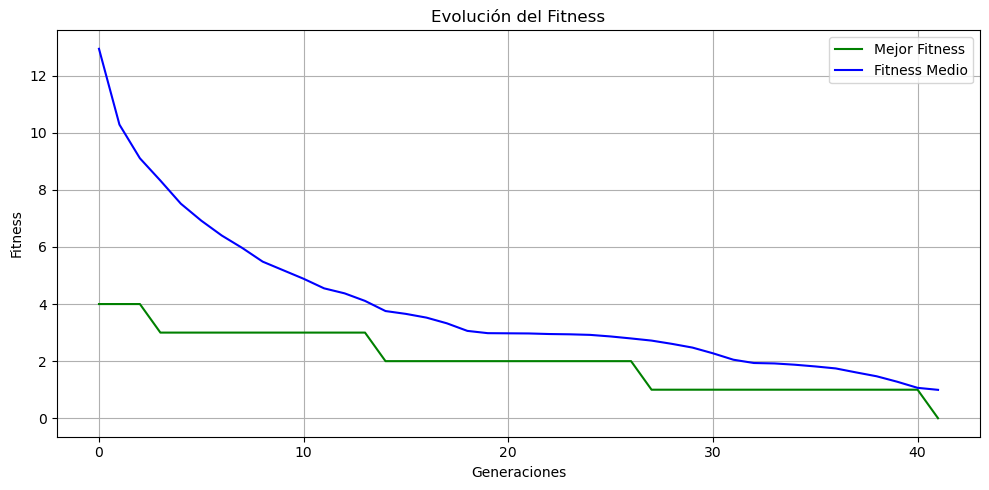


--- Repetici√≥n 6 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [17, 11, 3, 7, 4, 8, 18, 0, 15, 6, 1, 9, 14, 12, 19, 7, 2, 13, 3, 8]
Fitness: 0


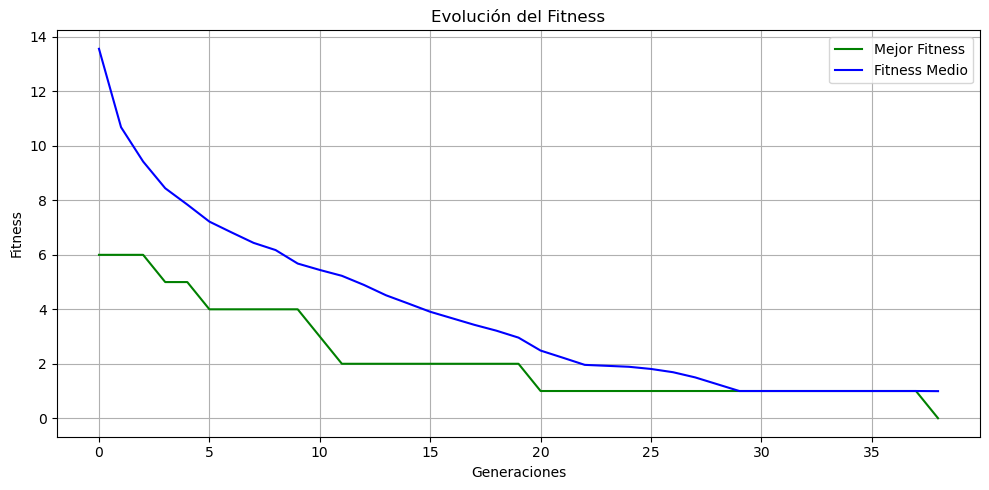


--- Repetici√≥n 7 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [15, 0, 4, 10, 8, 14, 18, 3, 1, 19, 15, 6, 2, 16, 12, 7, 5, 14, 9, 19]
Fitness: 0


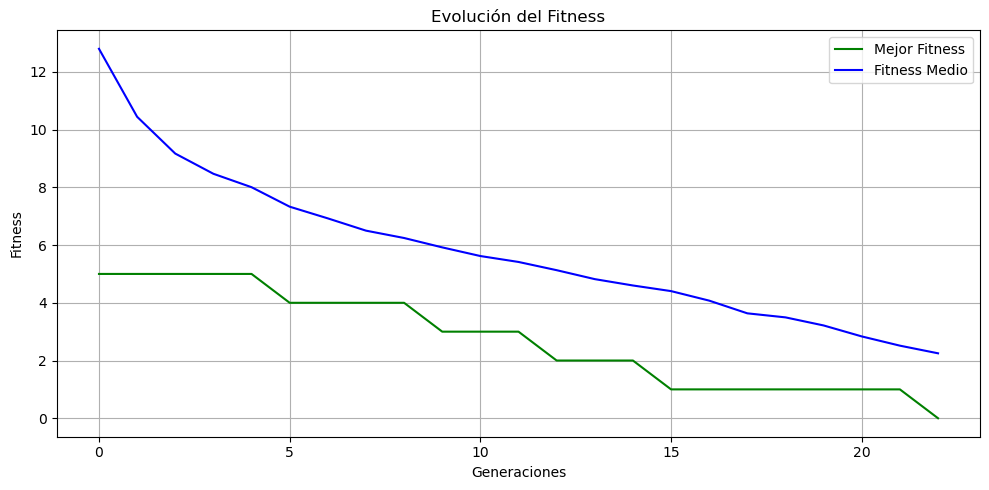


--- Repetici√≥n 8 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [19, 6, 15, 1, 19, 8, 2, 7, 3, 11, 0, 17, 6, 12, 18, 16, 13, 4, 9, 5]
Fitness: 0


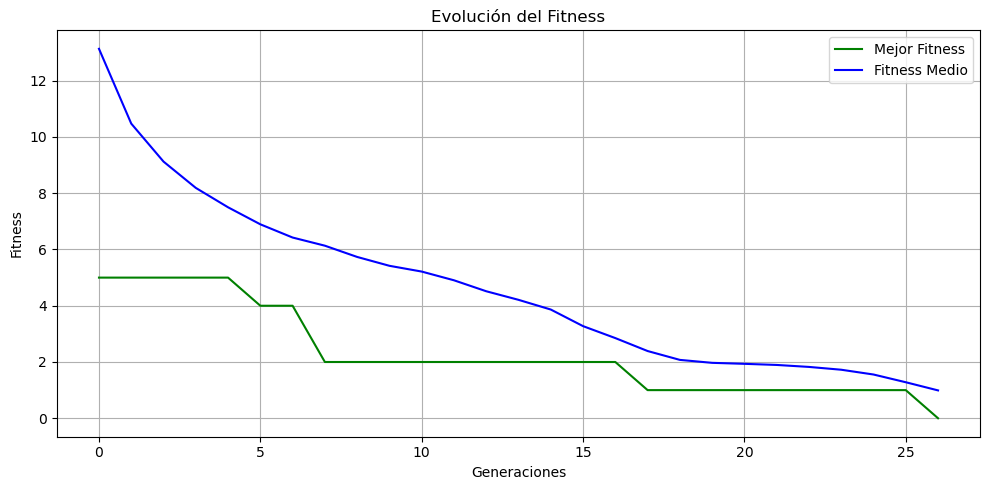


--- Repetici√≥n 9 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [13, 16, 19, 7, 1, 10, 18, 9, 15, 17, 4, 11, 15, 12, 6, 16, 12, 2, 0, 14]
Fitness: 0


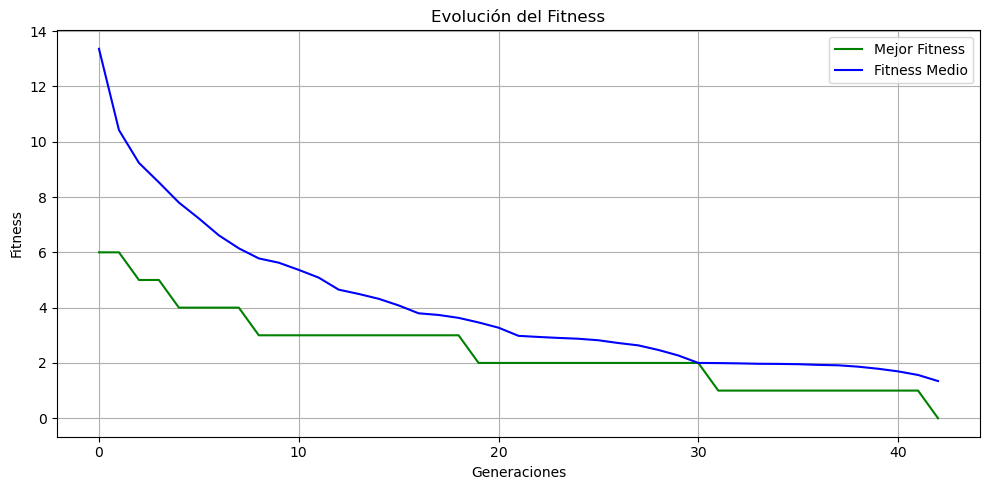


--- Repetici√≥n 10 ---
Resolviendo el problema de las 20-reinas:
Tama√±o de la poblaci√≥n: 200
N√∫mero de iteraciones: 500
Fitness final: 0
Cromosoma: [12, 6, 2, 11, 13, 16, 10, 3, 5, 0, 9, 18, 15, 19, 1, 8, 4, 7, 4, 14]
Fitness: 0


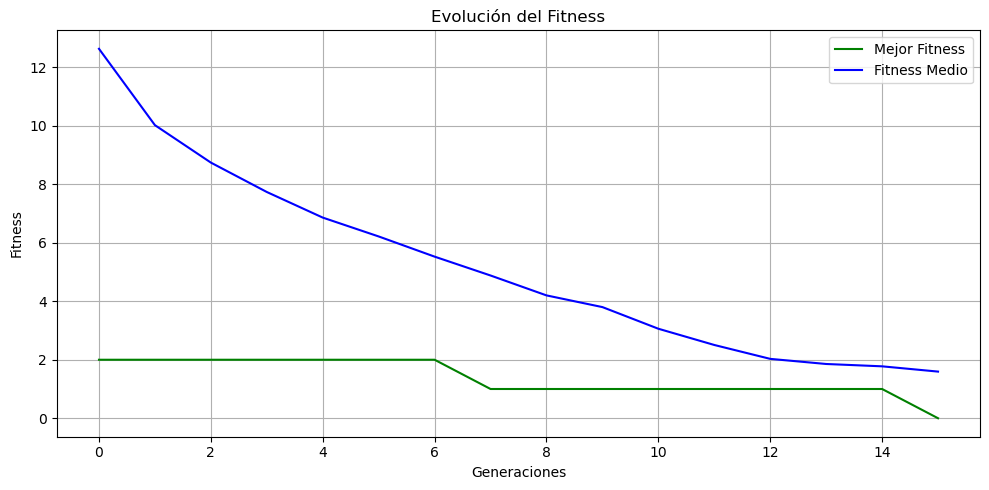

In [ ]:
N = 20
N_poblacion = 200
num_iteraciones = 500
num_repeticiones = 10

for i in range(num_repeticiones):
    print(f"\n--- Repetici√≥n {i+1} ---")

    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=N,
        f_fitness=fitness,
        f_mutacion=mutar_individuo_intercambio,
        prob_cruz=0.9,
        prob_mut=0.3,
        num_iteraciones=num_iteraciones
    )

    print(f"Resolviendo el problema de las {N}-reinas:")
    print(f"Tama√±o de la poblaci√≥n: {N_poblacion}")
    print(f"N√∫mero de iteraciones: {num_iteraciones}")
    print(f"Fitness final: {mejor_fitness}")
    mejor_solucion.mostrar_individuo()
    mostrar_historial_fitness(mejor_fitness_generacion, fitness_medio_generacion)


Se observa que la mayor generaci√≥n de descendientes, junto con el uso de una mutaci√≥n por intercambio, permite al algoritmo resolver el problema en un n√∫mero reducido de generaciones. Las gr√°ficas evidencian una mejora constante en la calidad del mejor cromosoma, con avances significativos cada pocas generaciones.

## 5. Efecto de los distintos tipos de cruzamiento:

El cruzamiento es es un proceso clave en los AG-s. Para analizar su efecto, vamos a visualizar como se comportan el mejor fitness por generaci√≥n y el fitness medio por generaci√≥n utilizando distintos tipos de cruzamiento:

- Cruzamiento por orden
- Cruzamiento parcialmente mapeado (PMX)

Creamos la funci√≥n encargada de realizar el cruzamiento por orden:

In [ ]:
def cruzar_progenitores_ox(progenitor1: 'Individuo', progenitor2: 'Individuo') -> 'Individuo':
    """
    Realiza el cruzamiento por orden (Order Crossover - OX) entre dos progenitores.

    :param progenitor1: Primer progenitor (objeto Individuo).
    :param progenitor2: Segundo progenitor (objeto Individuo).
    :return: Cromosoma resultante del cruzamiento (objeto Individuo).
    """
    import random

    p1 = progenitor1.cromosoma
    p2 = progenitor2.cromosoma
    N = len(p1)

    # Selecci√≥n de dos puntos de corte
    punto1, punto2 = sorted(random.sample(range(N), 2))

    hijo = [None] * N

    # Copiar segmento de progenitor1 al hijo
    hijo[punto1:punto2] = p1[punto1:punto2]

    # Rellenar con genes de progenitor2, en orden, sin duplicar
    pos_hijo = punto2 % N
    pos_p2 = punto2 % N

    while None in hijo:
        gen = p2[pos_p2 % N]
        if gen not in hijo:
            hijo[pos_hijo % N] = gen
            pos_hijo += 1
        pos_p2 += 1

    return Individuo(N_cromosoma=N,
                     f_fitness=progenitor1.f_fitness,
                     cromosoma=hijo)

Modificamos el algoritmo gen√©tico para poder elegir el m√©todo de cruzamiento:

In [ ]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       f_mutacion: Callable[['Individuo'], 'Individuo'],
       f_cruzamiento: Callable[['Individuo'], 'Individuo'],
       prob_progenitor: float = 0.4,
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       num_iteraciones: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo gen√©tico para resolver el problema de las N-reinas.

    :param N_poblacion: N√∫mero de individuos en la poblaci√≥n.
    :param N_cromosoma: Tama√±o del cromosoma (N del problema).
    :param f_fitness: Funci√≥n de evaluaci√≥n de fitness.
    :param f_mutacion: Funci√≥n de mutaci√≥n de los cromosomas.
    :param prob_progenitor: Probabilidad de que un individuo sea progenitor.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutaci√≥n.
    :param num_iteraciones: N√∫mero de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evoluci√≥n del fitness por generaci√≥n, y 
        la evoluci√≥n del fitness medio por generaci√≥n.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    for i in range(num_iteraciones):    
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)
        
        if np.min(poblacion.fitness_poblacion) == 0:
            break

        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores_ruleta(poblacion=poblacion, N_progenitores=int(N_poblacion*prob_progenitor))
        for i in range(0, len(progenitores)-1):
            progenitor1, progenitor2 = progenitores[i], progenitores[i+1]

            if np.random.rand() <= prob_cruz:
                # Generamos el primer hijo
                hijo1 = f_cruzamiento(progenitor1=progenitor1, 
                                        progenitor2=progenitor2)

                if np.random.rand() <= prob_mut:
                    hijo1 = f_mutacion(hijo1)
                descendientes.append(hijo1)

                # Generamos el segundo hijo
                hijo2 = f_cruzamiento(progenitor1=progenitor2, 
                                        progenitor2=progenitor1)

                if np.random.rand() <= prob_mut:
                    hijo2 = f_mutacion(hijo2)
                descendientes.append(hijo2)

        poblacion = seleccionar_mejores_supervivientes(poblacion=poblacion, descendientes=descendientes)

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Para medir el rendimiento, modificaremos la funci√≥n creada anteriormente:

In [ ]:
# Funci√≥n para ejecutar el AG y medir el rendimiento
def medir_rendimiento(N, num_iteraciones=500, poblaciones=[40, 60, 80, 100, 200, 400], f_cruzamientos=[mutar_individuo_sacudida], num_pruebas=10):
    resultados = {}

    for poblacion in poblaciones:
        resultados[poblacion] = {}
        for f_cruzamiento in f_cruzamientos:
            tiempos = []
            generaciones = []
            exitosas = 0

            for _ in range(num_pruebas):

                start_time = time.time()
                
                mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
                    N_poblacion=poblacion,
                    N_cromosoma=N,
                    f_fitness=fitness,
                    f_mutacion=mutar_individuo_intercambio,
                    f_cruzamiento=f_cruzamiento,
                    prob_progenitor=0.4,
                    prob_cruz=0.9,
                    prob_mut=0.3,
                    num_iteraciones=num_iteraciones
                )
                
                tiempo_ejecucion = time.time() - start_time
                tiempos.append(tiempo_ejecucion)
                generaciones.append(len(mejor_fitness_generacion))
                
                if mejor_fitness == 0:
                    exitosas += 1
            
            # Promedio de tiempo y generaciones
            promedio_tiempo = np.mean(tiempos)
            promedio_generaciones = np.mean(generaciones)
            exito = exitosas / num_pruebas * 100
            
            # Almacenar los resultados
            resultados[poblacion][f_cruzamiento.__name__] = {
                "promedio_tiempo": promedio_tiempo,
                "promedio_generaciones": promedio_generaciones,
                "exito": exito
            }
    
    return resultados

Ejecutamos la prueba para N = 20.

In [ ]:
# Ejecutar la medici√≥n para N=20
resultados = medir_rendimiento(N=20, 
                               num_iteraciones=500, 
                               poblaciones=[200],
                               f_cruzamientos=[cruzar_progenitores_ox, 
                                             cruzar_progenitores_pmx],
                               num_pruebas=10)

In [ ]:
resultados_df = pd.DataFrame([
    {'Poblacion': p, 'Mutacion': m, **metrics}
    for p, mutaciones in resultados.items()
    for m, metrics in mutaciones.items()
])
resultados_df

Poblacion                 Mutacion  promedio_tiempo  promedio_generaciones  \
0        200   cruzar_progenitores_ox         4.194090                  137.1   
1        200  cruzar_progenitores_pmx         2.304294                   77.7   

   exito  
0   90.0  
1  100.0

El comportamiento de PMX favorece una exploraci√≥n m√°s eficiente del espacio de b√∫squeda, ya que produce descendientes similares pero no id√©nticos a sus padres. Esto ayuda a refinar soluciones prometedoras con mayor rapidez.

Los resultados experimentales muestran que PMX es superior: alcanz√≥ una tasa de √©xito del 100% en las ejecuciones realizadas, con menos generaciones y menor tiempo promedio que otros m√©todos de cruzamiento evaluados.

Por estas razones, se concluye que PMX es el m√©todo m√°s adecuado para resolver el problema de las N-reinas mediante algoritmos gen√©ticos.

## 6. M√°ximo N resuelto:

Para concluir con el trabajo, trataremos de encontrar cual es el mayor N que puede alcanzar a solucionar nuestro algoritmo gen√©tico:

In [ ]:
N_max = 100
N_poblacion = 50
num_iteraciones = 500
num_ejecuciones = 3

for n in range(N_max, N_max + 1, 5):
    mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
        N_poblacion=N_poblacion,
        N_cromosoma=n,
        f_fitness=fitness,
        f_mutacion=mutar_individuo_intercambio,
        f_cruzamiento=cruzar_progenitores_pmx,
        prob_cruz=0.9,
        prob_mut=0.3,
        num_iteraciones=num_iteraciones
    )

    print(f"-- {n}-Reinas --")
    print(f"Fitness final: {mejor_fitness}")
    mejor_solucion.mostrar_individuo()
    mostrar_historial_fitness(mejor_fitness_generacion, fitness_medio_generacion)

TypeError: AG() got an unexpected keyword argument 'f_mutacion'

In [ ]:
array = np.array(mejor_solucion.cromosoma)

In [ ]:
np.unique(array).shape

(84,)

In [ ]:
array.shape

(100,)